# Install necessary libraries

In [2]:
# needed to install heart diseases dataset
! pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

! pip install gower
import gower
import numpy as np
import requests
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helper Functions

## Distance functions

In [3]:
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2) ** 2, axis = -1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis = -1)

## KNN Implementation

In [4]:
class WeightedKNN:
    def __init__(self, K = 1, distance_function = euclidean, precomputed=False):
        self.C = None  # Number of unique classes
        self.y = None  # Labels
        self.x = None  # Features
        self.distance_function = distance_function
        self.K = K  # Number of neighbors
        self.precomputed = precomputed  # Flag for precomputed distances

    def fit(self, x_train, y_train):
        """Stores the training data."""
        if not self.precomputed:
            self.x = x_train.values if isinstance(x_train, pd.DataFrame) else x_train
        self.y = y_train.values if isinstance(y_train, pd.Series) else y_train
        self.C = len(np.unique(self.y))
        return self

    def predict(self, x_test, dist_matrix=None):
        """Predicts the class labels for the test data."""
        if self.precomputed:
            if dist_matrix is not None:
              distances = dist_matrix
        else:
            x_test = x_test.values if isinstance(x_test, pd.DataFrame) else x_test
            distances = self.distance_function (self.x[None, :, :], x_test[:, None, :])

        num_test = distances.shape[0]
        predictions = np.zeros(num_test, dtype=int)
        probabilities = np.zeros((num_test, self.C))  # For class probabilities

        for i in range(num_test):
            knn_indices = np.argsort(distances[i])[:self.K]  # Get K nearest neighbors
            knn_distances = distances[i][knn_indices]
            knn_labels = self.y[knn_indices]
            weights = 1 / (knn_distances + 1e-8)  # Weight inversely proportional to distance
            weighted_votes = np.zeros(self.C)

            for idx, label in enumerate(knn_labels):
                weighted_votes[label] += weights[idx]

            predictions[i] = np.argmax(weighted_votes)
            probabilities[i, :] = weighted_votes / np.sum(weighted_votes)

        return predictions, probabilities

    @staticmethod
    def evaluate_acc(prediction, y_true):
        """Calculates the accuracy."""
        if isinstance(prediction, tuple):
            prediction = prediction[0]
        if prediction.ndim == 2:
            prediction = np.argmax(prediction, axis=1)
        return np.mean(prediction == y_true)

## Decision tree cost functions

In [5]:
# Cost function: Misclassification
def cost_misclassification(labels):
    """
    Computes the misclassification cost for a set of labels.
    Args:
        labels (array-like): Array of class labels.
    Returns:
        float: Misclassification cost.
    """
    labels = np.array(labels)  # Ensure labels are a numpy array
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    return 1 - np.max(class_probs)

# Cost function: Entropy
def cost_entropy(labels):
    """
    Computes the entropy cost for a set of labels.
    Args:
        labels (array-like): Array of class labels.
    Returns:
        float: Entropy cost.
    """
    labels = np.array(labels)  # Ensure labels are a numpy array
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]  # Remove probabilities equal to 0
    return -np.sum(class_probs * np.log2(class_probs))

# Cost function: Gini Index
def cost_gini_index(labels):
    """
    Computes the Gini index cost for a set of labels.
    Args:
        labels (array-like): Array of class labels.
    Returns:
        float: Gini index cost.
    """
    labels = np.array(labels)  # Ensure labels are a numpy array
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))  # Gini index formula

## Decison tree node

In [6]:
class Node:
    def __init__(self, data_indices, parent = None):
        self.data_indices = data_indices
        self.left = None
        self.right = None
        self.split_feature = None
        self.split_value = None
        self.class_prob = None
        if parent:
            self.depth = parent.depth + 1
            self.num_classes = parent.num_classes
            self.data = parent.data
            self.labels = parent.labels
            class_prob = np.bincount(self.labels[data_indices], minlength = self.num_classes)
            self.class_prob = class_prob / np.sum(class_prob)

## Greedy search for the best split

In [7]:
def greedy_test(node, cost_function):
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    data_sorted = np.sort(node.data[node.data_indices], axis = 0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.0

    for f in range(num_features):
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:, f]:
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            left_cost = cost_function(node.labels[left_indices])
            right_cost = cost_function(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            cost = (num_left * left_cost + num_right * right_cost) / num_instances
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

## Decision tree Implementation

In [8]:
class DT:
    def __init__(self, num_classes = None, max_depth = 3, cost_function = cost_misclassification, min_leaf_instances = 1):
        self.max_depth = max_depth
        self.root = None
        self.cost_function = cost_function
        self.num_classes = num_classes
        self.min_leaf_instances = min_leaf_instances

    def fit(self, data, labels):
        if isinstance(data, pd.DataFrame):
            data = data.to_numpy()
        self.data = data
        self.labels = labels
        if self.num_classes is None:
            self.num_classes = np.max(labels) + 1
        self.root = Node(np.arange(data.shape[0]), None)
        self.root.data = data
        self.root.labels = labels
        self.root.num_classes = self.num_classes
        self.root.depth = 0
        self._fit_tree(self.root)
        return self

    def _fit_tree(self, node):
        if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
            return
        cost, split_feature, split_value = greedy_test(node, self.cost_function)
        if np.isinf(cost):
            return
        test = node.data[node.data_indices, split_feature] <= split_value
        node.split_feature = split_feature
        node.split_value = split_value
        left = Node(node.data_indices[test], node)
        right = Node(node.data_indices[~test], node)
        self._fit_tree(left)
        self._fit_tree(right)
        node.left = left
        node.right = right

    def predict(self, data_test):
        if isinstance(data_test, pd.DataFrame):
            data_test = data_test.to_numpy()
        class_probs = np.zeros((data_test.shape[0], self.num_classes))
        predictions = np.zeros(data_test.shape[0], dtype = int)
        for n, x in enumerate(data_test):
            node = self.root
            while node.left:
                if x[node.split_feature] <= node.split_value:
                    node = node.left
                else:
                    node = node.right
            class_probs[n, :] = node.class_prob
            predictions[n] = np.argmax(node.class_prob)
        return predictions, class_probs

## Display confusion matrix

In [9]:
def get_cm(y_test, predictions, y_train):
    cm = confusion_matrix(y_test, predictions)
    class_labels = np.unique(y_train)
    cm_df = pd.DataFrame(cm, index=[f'Actual {label}' for label in class_labels],
                         columns=[f'Predicted {label}' for label in class_labels])
    print(f"Confusion Matrix:\n{cm_df}\n")

# Penguin Dataset

## Loading the dataset

In [10]:
penguin_df = pd.read_csv('/content/drive/My Drive/COMP 551/Assignment 1/penguins_size.csv', index_col = 0)

## Examining the dataset

In [11]:
print('First 5 rows of dataset')
print(penguin_df.head())
print('\nInfo of dataset')
print(penguin_df.info())

First 5 rows of dataset
            island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
species                                                                    
Adelie   Torgersen              39.1             18.7              181.0   
Adelie   Torgersen              39.5             17.4              186.0   
Adelie   Torgersen              40.3             18.0              195.0   
Adelie   Torgersen               NaN              NaN                NaN   
Adelie   Torgersen              36.7             19.3              193.0   

         body_mass_g     sex  
species                       
Adelie        3750.0    MALE  
Adelie        3800.0  FEMALE  
Adelie        3250.0  FEMALE  
Adelie           NaN     NaN  
Adelie        3450.0  FEMALE  

Info of dataset
<class 'pandas.core.frame.DataFrame'>
Index: 344 entries, Adelie to Gentoo
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   i

## Cleaning the dataset

In [12]:
penguin_cleaned = penguin_df.drop(columns = ['island'])
penguin_cleaned = penguin_cleaned.dropna(subset = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex'])
penguin_cleaned['sex'] = penguin_cleaned['sex'].str.capitalize()

# print(penguin_cleaned.isnull().sum())
# print(penguin_cleaned['sex'].unique())

invalid_sex = penguin_cleaned[penguin_cleaned['sex'] == '.']
# print(invalid_sex)

penguin_cleaned = penguin_cleaned[penguin_cleaned['sex'] != '.']
# print(penguin_cleaned['sex'].unique())
# print(f"Number of rows in penguin_cleaned: {penguin_cleaned.shape[0]}")

penguin_cleaned['sex_encoded'] = penguin_cleaned['sex'].map({'Male': 1, 'Female': 0})

print(penguin_cleaned.info())


<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, Adelie to Gentoo
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   333 non-null    float64
 1   culmen_depth_mm    333 non-null    float64
 2   flipper_length_mm  333 non-null    float64
 3   body_mass_g        333 non-null    float64
 4   sex                333 non-null    object 
 5   sex_encoded        333 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 18.2+ KB
None


<ipython-input-12-1d9ebd343b20>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguin_cleaned['sex'] = penguin_cleaned['sex'].str.capitalize()


## Standardizing the dataset

In [13]:
scaler_penguin = StandardScaler()

# if you want to include the sex feature just add 'sex_encoded' to the list
numeric_columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']#, 'sex_encoded']
penguin_cleaned[numeric_columns] = scaler_penguin.fit_transform(penguin_cleaned[numeric_columns])
print(penguin_cleaned.shape[0])

333


## Basic statistics on the dataset

In [14]:
# Recalculate group means by species
group_means_penguin_standardized = penguin_cleaned.groupby('species')[numeric_columns].mean()

# Compute squared differences of means
squared_differences_penguin_std = (
    group_means_penguin_standardized.diff().iloc[-1] ** 2
).sort_values(ascending=False)

# Display results
print("Group Means by Species (Standardized):")
print(group_means_penguin_standardized)
print("\nRanked Features by Squared Difference of Means (Standardized):")
print(squared_differences_penguin_std)

# sex has a very small effect so we can drop it,  1.588871e-04
# penguin_cleaned = penguin_cleaned.drop(columns = 'sex_encoded')

Group Means by Species (Standardized):
           culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
species                                                                     
Adelie            -0.946592         0.601337          -0.776310    -0.622996
Chinstrap          0.886562         0.638630          -0.367527    -0.589509
Gentoo             0.654758        -1.102707           1.162463     1.101211

Ranked Features by Squared Difference of Means (Standardized):
culmen_depth_mm      3.032254
body_mass_g          2.858534
flipper_length_mm    2.340871
culmen_length_mm     0.053733
Name: Gentoo, dtype: float64


## KNN on the penguin (Euclidean Distance)

Best K (Euclidean): 3


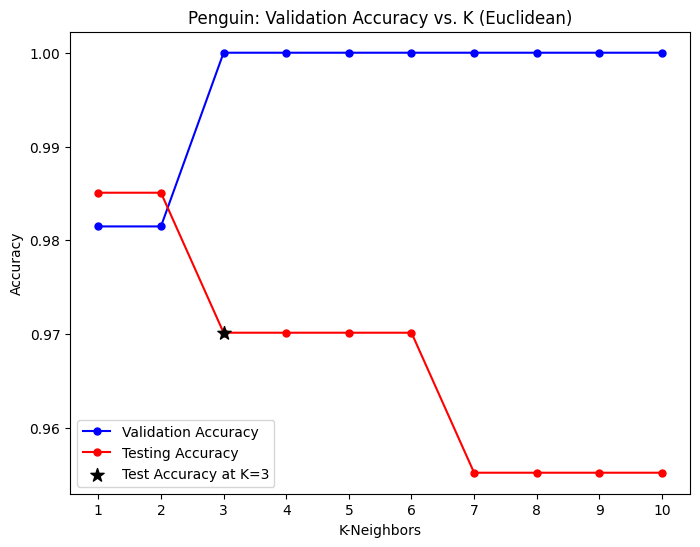

In [15]:
# Feature selection
penguin_features = numeric_columns
penguin_X = penguin_cleaned[penguin_features]

penguin_y, classes = pd.factorize(penguin_cleaned.index)

# Split data into train, validation, and test sets
penguin_X_train_full, penguin_X_test, penguin_y_train_full, penguin_y_test = train_test_split(
    penguin_X, penguin_y, test_size = 0.2, random_state = 5, shuffle = True
)

penguin_X_train, penguin_X_val, penguin_y_train, penguin_y_val = train_test_split(
    penguin_X_train_full, penguin_y_train_full, test_size=0.2, random_state=1, shuffle=True
)

# Validation phase: testing different values of K
k_values = range(1, 11)
eu_validation_accuracies = []
eu_validation_aurocs = []
for k in k_values:
    knn = WeightedKNN(K=k, distance_function=euclidean)
    knn.fit(penguin_X_train, penguin_y_train)
    val_prediction, val_proba = knn.predict(penguin_X_val)
    val_acc = knn.evaluate_acc(val_prediction, penguin_y_val)
    eu_validation_accuracies.append(val_acc)

    # Compute AUROC
    auc_all = []
    for class_idx in range(len(classes)):
        binary_true = (penguin_y_val == class_idx).astype(int)
        fpr, tpr, _ = roc_curve(binary_true, val_proba[:, class_idx])
        auc_all.append(auc(fpr, tpr))
    val_auc = np.mean(auc_all)
    eu_validation_aurocs.append(val_auc)

# Test set: Euclidean accuracy for all Ks
eu_test_accuracies = []
KNN_eu_test_aurocs = []
for k in k_values:
    knn = WeightedKNN(K=k, distance_function=euclidean)
    knn.fit(penguin_X_train_full, penguin_y_train_full)
    test_prediction, test_proba = knn.predict(penguin_X_test)
    k_test_accuracy = knn.evaluate_acc(test_prediction, penguin_y_test)
    eu_test_accuracies.append(k_test_accuracy)

    # Compute AUROC
    auc_all = []
    for class_idx in range(len(classes)):
        binary_true = (penguin_y_test == class_idx).astype(int)
        fpr, tpr, _ = roc_curve(binary_true, test_proba[:, class_idx])
        auc_all.append(auc(fpr, tpr))
    test_auc = np.mean(auc_all)
    KNN_eu_test_aurocs.append(test_auc)

# Best K evaluation for Euclidean
eu_best_k = k_values[np.argmax(eu_validation_accuracies)]
print("Best K (Euclidean):", eu_best_k)
final_knn = WeightedKNN(K=eu_best_k, distance_function=euclidean)
final_knn.fit(penguin_X_train_full, penguin_y_train_full)
test_prediction, final_test_proba = final_knn.predict(penguin_X_test)
eu_best_k_test_accuracy = final_knn.evaluate_acc(test_prediction, penguin_y_test)

# Compute best K's AUROC
fpr_all, tpr_all, auc_all = [], [], []
for class_idx in range(len(classes)):
    binary_true = (penguin_y_test == class_idx).astype(int)
    fpr, tpr, _ = roc_curve(binary_true, final_test_proba[:, class_idx])
    roc_auc = roc_auc_score(binary_true, final_test_proba[:, class_idx])
    fpr_all.append(fpr)
    tpr_all.append(tpr)
    auc_all.append(auc(fpr, tpr))
final_test_auc = np.mean(auc_all)

# Plot Validation vs Testing Accuracy
plt.figure(figsize = (8, 6))
plt.plot(k_values, eu_validation_accuracies, marker='o', color='b', linestyle='-', markersize=5, label="Validation Accuracy")
plt.plot(k_values, eu_test_accuracies, marker='o', color='r', linestyle='-', markersize=5, label="Testing Accuracy")
plt.scatter(eu_best_k, eu_best_k_test_accuracy, color='black', marker="*", s=100, label=f'Test Accuracy at K={eu_best_k}', zorder=5)
plt.title("Penguin: Validation Accuracy vs. K (Euclidean)")
plt.xlabel("K-Neighbors")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.legend(loc='best')
plt.show()

## KNN on penguin (Manhattan distance)

Best K is: 3


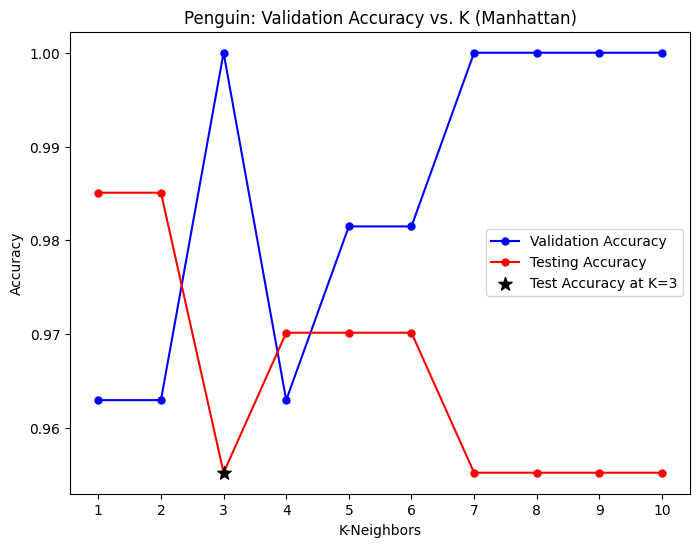

In [16]:
# Validation phase: testing different values of K
k_values = range(1, 11)
Mh_validation_accuracies = []
Mh_validation_aurocs = []
for k in k_values:
    knn = WeightedKNN(K=k, distance_function=manhattan)
    knn.fit(penguin_X_train, penguin_y_train)
    val_prediction, val_proba = knn.predict(penguin_X_val)
    val_acc = knn.evaluate_acc(val_prediction, penguin_y_val)
    Mh_validation_accuracies.append(val_acc)

    # Compute AUROC
    fpr_all, tpr_all, auc_all = [], [], []
    for class_idx in range(len(classes)):
        binary_true = (penguin_y_val == class_idx).astype(int)
        fpr, tpr, _ = roc_curve(binary_true, val_proba[:, class_idx])
        fpr_all.append(fpr)
        tpr_all.append(tpr)
        auc_all.append(auc(fpr, tpr))
    val_auc = np.mean(auc_all)
    Mh_validation_aurocs.append(val_auc)


# Best K evaluation
Mh_best_k = k_values[np.argmax(Mh_validation_accuracies)]
print("Best K is:", Mh_best_k)
final_knn = WeightedKNN(K=Mh_best_k, distance_function=manhattan)
final_knn.fit(penguin_X_train_full, penguin_y_train_full)
test_prediction, final_test_proba = final_knn.predict(penguin_X_test)
Mh_best_k_test_accuracy = final_knn.evaluate_acc(test_prediction, penguin_y_test)

# Compute best K's AUROC
fpr_all, tpr_all, auc_all = [], [], []
for class_idx in range(len(classes)):
    binary_true = (penguin_y_test == class_idx).astype(int)
    fpr, tpr, _ = roc_curve(binary_true, final_test_proba[:, class_idx])
    roc_auc = roc_auc_score(binary_true, final_test_proba[:, class_idx])
    fpr_all.append(fpr)
    tpr_all.append(tpr)
    auc_all.append(auc(fpr, tpr))
final_test_auc = np.mean(auc_all)


# Test set: getting accuracy of all Ks
Mh_test_accuracies = []
KNN_Mh_test_aurocs = []
for k in k_values:
    knn = WeightedKNN(K=k, distance_function=manhattan)
    knn.fit(penguin_X_train_full, penguin_y_train_full)
    test_prediction, test_proba = knn.predict(penguin_X_test)
    k_test_accuracy = knn.evaluate_acc(test_prediction, penguin_y_test)
    Mh_test_accuracies.append(k_test_accuracy)

    # Compute AUROC
    fpr_all, tpr_all, auc_all = [], [], []
    for class_idx in range(len(classes)):
        binary_true = (penguin_y_test == class_idx).astype(int)
        fpr, tpr, _ = roc_curve(binary_true, test_proba[:, class_idx])
        fpr_all.append(fpr)
        tpr_all.append(tpr)
        auc_all.append(auc(fpr, tpr))
    test_auc = np.mean(auc_all)
    KNN_Mh_test_aurocs.append(test_auc)


# Plot Validation vs Testing Accuracy
plt.figure(figsize=(8, 6))
plt.plot(k_values, Mh_validation_accuracies, marker='o', color='b', linestyle='-', markersize=5, label="Validation Accuracy")
plt.plot(k_values, Mh_test_accuracies, marker='o', color='r', linestyle='-', markersize=5, label="Testing Accuracy")
plt.scatter(Mh_best_k, Mh_best_k_test_accuracy, color='black', marker="*", s=100, label=f'Test Accuracy at K={Mh_best_k}', zorder=5)
plt.title("Penguin: Validation Accuracy vs. K (Manhattan)")
plt.xlabel("K-Neighbors")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.legend(loc='best')
plt.show()

## Penguin Dataset : Comparing Distance Functions for KNN

Best K for Euclidean Distance: 3
Best K for Manhattan Distance: 3


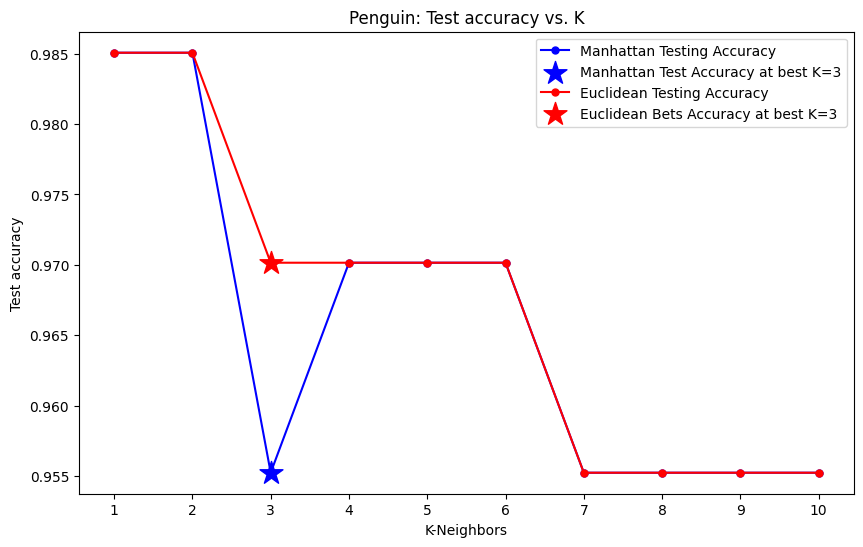

In [17]:
print("Best K for Euclidean Distance:", eu_best_k)
print("Best K for Manhattan Distance:", Mh_best_k)

plt.figure(figsize=(10, 6))
plt.plot(k_values, Mh_test_accuracies, marker='o', color='b', linestyle='solid', markersize=5, label="Manhattan Testing Accuracy")
plt.scatter(Mh_best_k, Mh_best_k_test_accuracy, color='b', marker="*", s=300, label=f'Manhattan Test Accuracy at best K={Mh_best_k}', zorder=5)

plt.plot(k_values, eu_test_accuracies, marker='o', color='r', linestyle='solid', markersize=5, label="Euclidean Testing Accuracy")
plt.scatter(eu_best_k, eu_best_k_test_accuracy, color='r', marker="*", s=300, label=f'Euclidean Bets Accuracy at best K={eu_best_k}', zorder=5)

plt.title("Penguin: Test accuracy vs. K")
plt.xlabel("K-Neighbors")
plt.ylabel("Test accuracy")
plt.xticks(k_values)
plt.legend(loc='best')
plt.show()


## Decision tree on the dataset (Gini - Index)

Best max depth is: 2


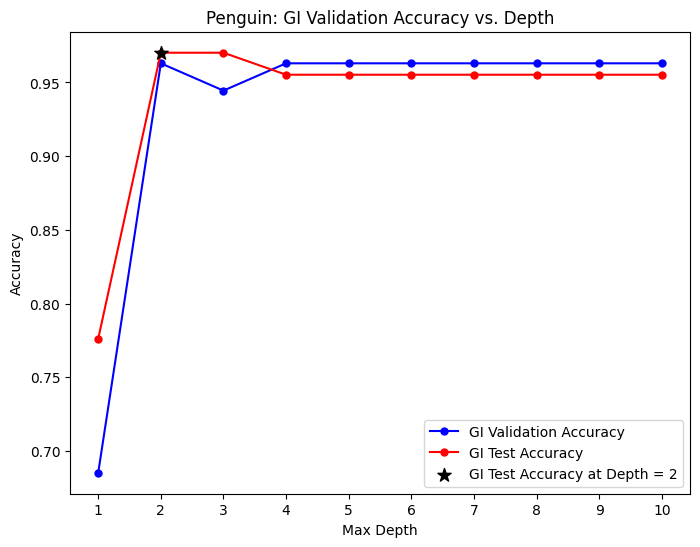

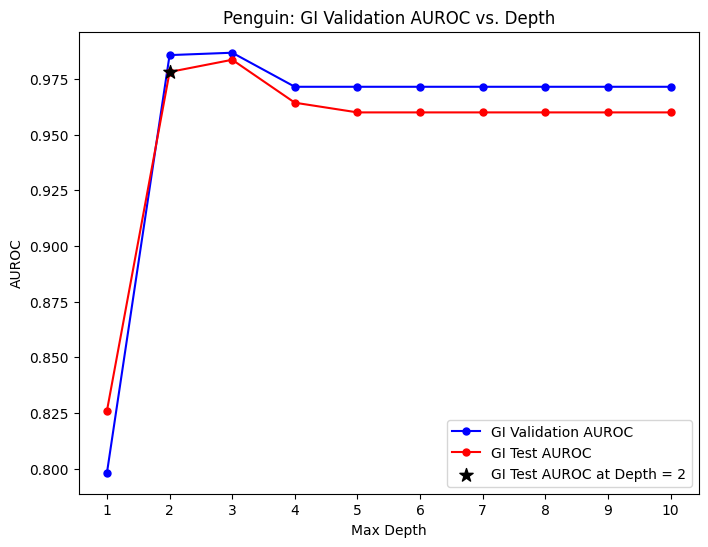

In [18]:
# Validation phase
d_values = range(1, 11)
GI_validation_accuracies = []
GI_validation_aurocs = []
for d in d_values:
    tree = DT(max_depth=d, cost_function=cost_gini_index)
    tree.fit(penguin_X_train, penguin_y_train)
    val_predictions, val_probs_test = tree.predict(penguin_X_val)

    # Compute validation accuracy
    val_acc = np.sum(val_predictions == penguin_y_val) / penguin_y_val.shape[0]
    GI_validation_accuracies.append(val_acc)

    # Compute AUROC
    fpr_all, tpr_all, auc_all = [], [], []
    for class_idx in range(len(classes)):
        binary_true = (penguin_y_val == class_idx).astype(int)
        fpr, tpr, _ = roc_curve(binary_true, val_probs_test[:, class_idx])
        auc_all.append(auc(fpr, tpr))
    val_auc = np.mean(auc_all)
    GI_validation_aurocs.append(val_auc)

# GINI Testing phase
GI_test_acc = []
DT_GI_test_aurocs = []
for d in d_values:
    tree = DT(max_depth=d, cost_function=cost_gini_index)
    tree.fit(penguin_X_train_full, penguin_y_train_full)
    test_predictions, test_probs_test = tree.predict(penguin_X_test)
    k_test_accuracy = np.sum(test_predictions == penguin_y_test) / penguin_y_test.shape[0]
    GI_test_acc.append(k_test_accuracy)

    # Compute AUROC
    fpr_all, tpr_all, auc_all = [], [], []
    for class_idx in range(len(classes)):
        binary_true = (penguin_y_test == class_idx).astype(int)
        fpr, tpr, _ = roc_curve(binary_true, test_probs_test[:, class_idx])
        auc_all.append(auc(fpr, tpr))
    test_auc = np.mean(auc_all)
    DT_GI_test_aurocs.append(test_auc)

# Best max depth
GI_best_d = d_values[np.argmax(GI_validation_accuracies)]
print("Best max depth is:", GI_best_d)
GI_final_tree = DT(max_depth=GI_best_d, cost_function=cost_gini_index)
GI_final_tree.fit(penguin_X_train_full, penguin_y_train_full)
GI_final_test_predictions, GI_final_test_probs = GI_final_tree.predict(penguin_X_test)
GI_best_d_test_accuracy = np.sum(GI_final_test_predictions == penguin_y_test) / penguin_y_test.shape[0]

# Compute final AUROC
fpr_all, tpr_all, auc_all = [], [], []
for class_idx in range(len(classes)):
    binary_true = (penguin_y_test == class_idx).astype(int)
    fpr, tpr, _ = roc_curve(binary_true, GI_final_test_probs[:, class_idx])
    auc_all.append(auc(fpr, tpr))
GI_final_test_auc = np.mean(auc_all)

# Validation vs Test Accuracy
plt.figure(figsize=(8, 6))
plt.plot(d_values, GI_validation_accuracies, marker='o', color='b', linestyle='-', markersize=5, label="GI Validation Accuracy")
plt.plot(d_values, GI_test_acc, marker='o', color='r', linestyle='-', markersize=5, label="GI Test Accuracy")
plt.scatter(GI_best_d, GI_best_d_test_accuracy, color='black', marker="*", s=100, label=f'GI Test Accuracy at Depth = {GI_best_d}', zorder=5)
plt.title("Penguin: GI Validation Accuracy vs. Depth")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.xticks(d_values)
plt.legend(loc='best')
plt.show()

# Validation vs Test AUROC
plt.figure(figsize=(8, 6))
plt.plot(d_values, GI_validation_aurocs, marker='o', color='b', linestyle='-', markersize=5, label="GI Validation AUROC")
plt.plot(d_values, DT_GI_test_aurocs, marker='o', color='r', linestyle='-', markersize=5, label="GI Test AUROC")
plt.scatter(GI_best_d, GI_final_test_auc, color='black', marker="*", s=100, label=f'GI Test AUROC at Depth = {GI_best_d}', zorder=5)
plt.title("Penguin: GI Validation AUROC vs. Depth")
plt.xlabel("Max Depth")
plt.ylabel("AUROC")
plt.xticks(d_values)
plt.legend(loc='best')
plt.show()



## DT on penguin (Entropy)

Best max depth is: 2


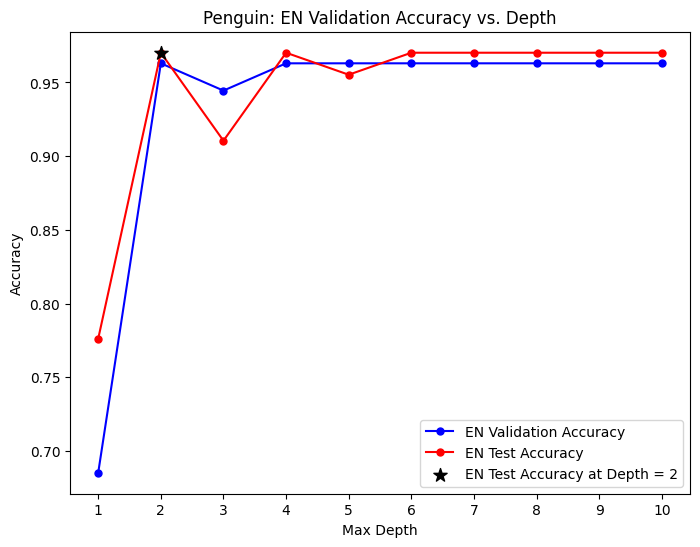

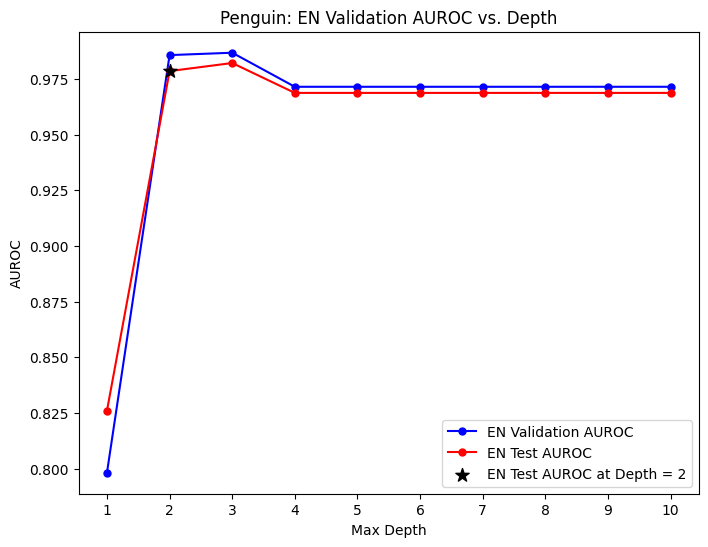

In [19]:
EN_validation_accuracies = []
EN_validation_aurocs = []
for d in d_values:
    tree = DT(max_depth=d, cost_function=cost_entropy)
    tree.fit(penguin_X_train, penguin_y_train)
    val_predictions, val_probs_test = tree.predict(penguin_X_val)

    # Compute validation accuracy
    val_acc = np.sum(val_predictions == penguin_y_val) / penguin_y_val.shape[0]
    EN_validation_accuracies.append(val_acc)

    # Compute AUROC
    fpr_all, tpr_all, auc_all = [], [], []
    for class_idx in range(len(classes)):
        binary_true = (penguin_y_val == class_idx).astype(int)
        fpr, tpr, _ = roc_curve(binary_true, val_probs_test[:, class_idx])
        auc_all.append(auc(fpr, tpr))
    val_auc = np.mean(auc_all)
    EN_validation_aurocs.append(val_auc)

# EN Testing phase
EN_test_acc = []
DT_EN_test_aurocs = []
for d in d_values:
    tree = DT(max_depth=d, cost_function=cost_entropy)
    tree.fit(penguin_X_train_full, penguin_y_train_full)
    test_predictions, test_probs_test = tree.predict(penguin_X_test)
    k_test_accuracy = np.sum(test_predictions == penguin_y_test) / penguin_y_test.shape[0]
    EN_test_acc.append(k_test_accuracy)

    # Compute AUROC
    fpr_all, tpr_all, auc_all = [], [], []
    for class_idx in range(len(classes)):
        binary_true = (penguin_y_test == class_idx).astype(int)
        fpr, tpr, _ = roc_curve(binary_true, test_probs_test[:, class_idx])
        auc_all.append(auc(fpr, tpr))
    test_auc = np.mean(auc_all)
    DT_EN_test_aurocs.append(test_auc)

# Best max depth
EN_best_d = d_values[np.argmax(EN_validation_accuracies)]
print("Best max depth is:", EN_best_d)
EN_final_tree = DT(max_depth=EN_best_d, cost_function=cost_entropy)
EN_final_tree.fit(penguin_X_train_full, penguin_y_train_full)
EN_final_test_predictions, EN_final_test_probs = EN_final_tree.predict(penguin_X_test)
EN_best_d_test_accuracy = np.sum(EN_final_test_predictions == penguin_y_test) / penguin_y_test.shape[0]

# Compute final AUROC
fpr_all, tpr_all, auc_all = [], [], []
for class_idx in range(len(classes)):
    binary_true = (penguin_y_test == class_idx).astype(int)
    fpr, tpr, _ = roc_curve(binary_true, EN_final_test_probs[:, class_idx])
    auc_all.append(auc(fpr, tpr))
EN_final_test_auc = np.mean(auc_all)

# Validation vs Test Accuracy
plt.figure(figsize=(8, 6))
plt.plot(d_values, EN_validation_accuracies, marker='o', color='b', linestyle='-', markersize=5, label="EN Validation Accuracy")
plt.plot(d_values, EN_test_acc, marker='o', color='r', linestyle='-', markersize=5, label="EN Test Accuracy")
plt.scatter(EN_best_d, EN_best_d_test_accuracy, color='black', marker="*", s=100, label=f'EN Test Accuracy at Depth = {EN_best_d}', zorder=5)
plt.title("Penguin: EN Validation Accuracy vs. Depth")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.xticks(d_values)
plt.legend(loc='best')
plt.show()

# Validation vs Test AUROC
plt.figure(figsize=(8, 6))
plt.plot(d_values, EN_validation_aurocs, marker='o', color='b', linestyle='-', markersize=5, label="EN Validation AUROC")
plt.plot(d_values, DT_EN_test_aurocs, marker='o', color='r', linestyle='-', markersize=5, label="EN Test AUROC")
plt.scatter(EN_best_d, EN_final_test_auc, color='black', marker="*", s=100, label=f'EN Test AUROC at Depth = {EN_best_d}', zorder=5)
plt.title("Penguin: EN Validation AUROC vs. Depth")
plt.xlabel("Max Depth")
plt.ylabel("AUROC")
plt.xticks(d_values)
plt.legend(loc='best')
plt.show()


## DT on penguin (misclassification)

Best max depth is: 2


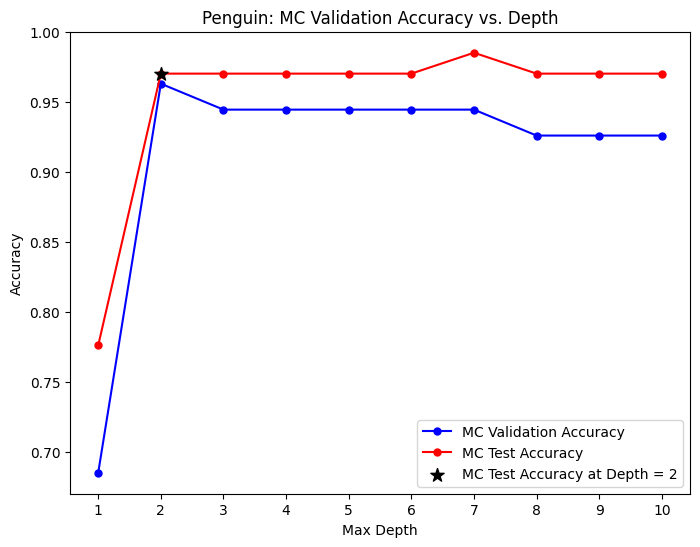

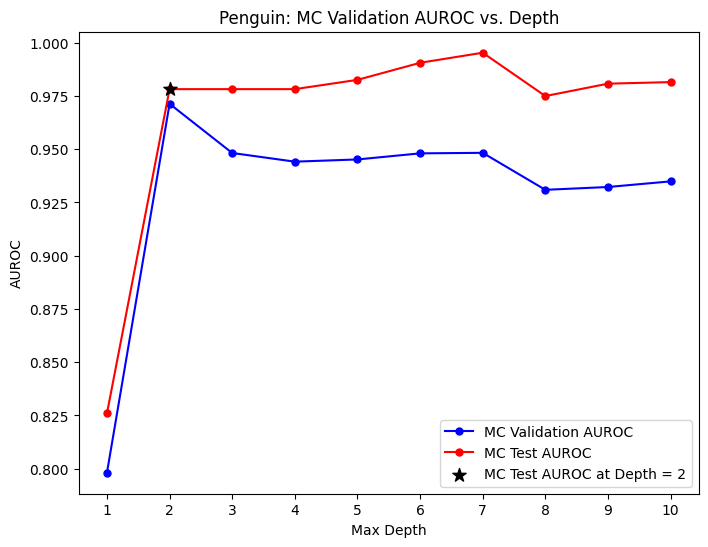

In [20]:
MC_validation_accuracies = []
MC_validation_aurocs = []
for d in d_values:
    tree = DT(max_depth=d, cost_function=cost_misclassification)
    tree.fit(penguin_X_train, penguin_y_train)
    val_predictions, val_probs_test = tree.predict(penguin_X_val)

    # Compute validation accuracy
    val_acc = np.sum(val_predictions == penguin_y_val) / penguin_y_val.shape[0]
    MC_validation_accuracies.append(val_acc)

    # Compute AUROC
    fpr_all, tpr_all, auc_all = [], [], []
    for class_idx in range(len(classes)):
        binary_true = (penguin_y_val == class_idx).astype(int)
        fpr, tpr, _ = roc_curve(binary_true, val_probs_test[:, class_idx])
        auc_all.append(auc(fpr, tpr))
    val_auc = np.mean(auc_all)
    MC_validation_aurocs.append(val_auc)

# MC Testing phase
MC_test_acc = []
DT_MC_test_aurocs = []
for d in d_values:
    tree = DT(max_depth=d, cost_function=cost_misclassification)
    tree.fit(penguin_X_train_full, penguin_y_train_full)
    test_predictions, test_probs_test = tree.predict(penguin_X_test)
    k_test_accuracy = np.sum(test_predictions == penguin_y_test) / penguin_y_test.shape[0]
    MC_test_acc.append(k_test_accuracy)

    # Compute AUROC
    fpr_all, tpr_all, auc_all = [], [], []
    for class_idx in range(len(classes)):
        binary_true = (penguin_y_test == class_idx).astype(int)
        fpr, tpr, _ = roc_curve(binary_true, test_probs_test[:, class_idx])
        auc_all.append(auc(fpr, tpr))
    test_auc = np.mean(auc_all)
    DT_MC_test_aurocs.append(test_auc)

# Best max depth
MC_best_d = d_values[np.argmax(MC_validation_accuracies)]
print("Best max depth is:", MC_best_d)
MC_final_tree = DT(max_depth=MC_best_d, cost_function=cost_misclassification)
MC_final_tree.fit(penguin_X_train_full, penguin_y_train_full)
MC_final_test_predictions, MC_final_test_probs = MC_final_tree.predict(penguin_X_test)
MC_best_d_test_accuracy = np.sum(MC_final_test_predictions == penguin_y_test) / penguin_y_test.shape[0]

# Compute final AUROC
fpr_all, tpr_all, auc_all = [], [], []
for class_idx in range(len(classes)):
    binary_true = (penguin_y_test == class_idx).astype(int)
    fpr, tpr, _ = roc_curve(binary_true, MC_final_test_probs[:, class_idx])
    auc_all.append(auc(fpr, tpr))
MC_final_test_auc = np.mean(auc_all)

# Validation vs Test Accuracy
plt.figure(figsize=(8, 6))
plt.plot(d_values, MC_validation_accuracies, marker='o', color='b', linestyle='-', markersize=5, label="MC Validation Accuracy")
plt.plot(d_values, MC_test_acc, marker='o', color='r', linestyle='-', markersize=5, label="MC Test Accuracy")
plt.scatter(MC_best_d, MC_best_d_test_accuracy, color='black', marker="*", s=100, label=f'MC Test Accuracy at Depth = {MC_best_d}', zorder=5)
plt.title("Penguin: MC Validation Accuracy vs. Depth")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.xticks(d_values)
plt.legend(loc='best')
plt.show()

# Validation vs Test AUROC
plt.figure(figsize=(8, 6))
plt.plot(d_values, MC_validation_aurocs, marker='o', color='b', linestyle='-', markersize=5, label="MC Validation AUROC")
plt.plot(d_values, DT_MC_test_aurocs, marker='o', color='r', linestyle='-', markersize=5, label="MC Test AUROC")
plt.scatter(MC_best_d, MC_final_test_auc, color='black', marker="*", s=100, label=f'MC Test AUROC at Depth = {MC_best_d}', zorder=5)
plt.title("Penguin: MC Validation AUROC vs. Depth")
plt.xlabel("Max Depth")
plt.ylabel("AUROC")
plt.xticks(d_values)
plt.legend(loc='best')
plt.show()

## Comparing Cost functions for DT (Gini, Entropy, Misclassification)

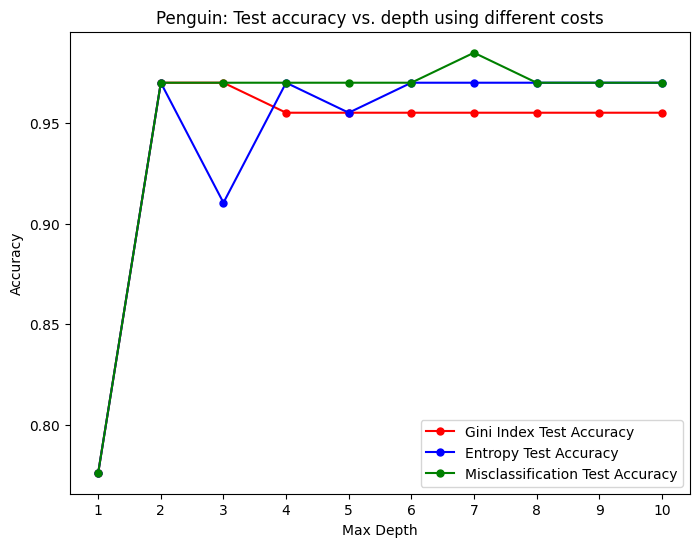

In [21]:
values = range(1,11)
plt.figure(figsize=(8, 6))
plt.plot(values, GI_test_acc, marker='o', color='r', linestyle='-', markersize=5, label="Gini Index Test Accuracy")
plt.plot(values, EN_test_acc, marker='o', color='b', linestyle='-', markersize=5, label="Entropy Test Accuracy")
plt.plot(values, MC_test_acc, marker='o', color='g', linestyle='-', markersize=5, label="Misclassification Test Accuracy")
plt.title("Penguin: Test accuracy vs. depth using different costs")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.xticks(values)
plt.legend(loc = 'best')
plt.show()

## Comparing accuracy between KNN and DT

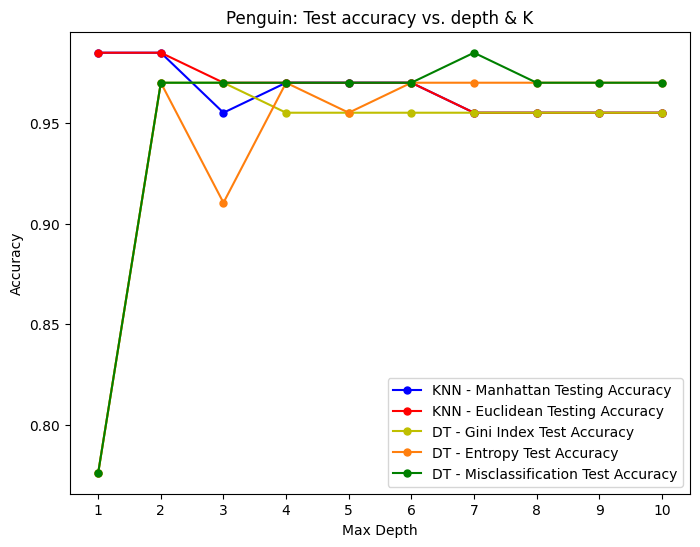

In [22]:
values = range(1,11)
plt.figure(figsize=(8, 6))
plt.plot(k_values, Mh_test_accuracies, marker='o', color='b', linestyle='-', markersize=5, label="KNN - Manhattan Testing Accuracy")
plt.plot(k_values, eu_test_accuracies, marker='o', color='r', linestyle='-', markersize=5, label="KNN - Euclidean Testing Accuracy")
plt.plot(values, GI_test_acc, marker='o', color='y', linestyle='-', markersize=5, label="DT - Gini Index Test Accuracy")
plt.plot(values, EN_test_acc, marker='o', color='C1', linestyle='-', markersize=5, label="DT - Entropy Test Accuracy")
plt.plot(values, MC_test_acc, marker='o', color='g', linestyle='-', markersize=5, label="DT - Misclassification Test Accuracy")
plt.title("Penguin: Test accuracy vs. depth & K")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.xticks(values)
plt.legend(loc = 'best')
plt.show()

# Heart Disease dataset

## Loading the dataset

In [23]:
# fetch Heart Disease dataset
heart_disease = fetch_ucirepo(id = 45)

# data (as pandas dataframes)
x = heart_disease.data.features
y = heart_disease.data.targets

## Examining the dataset

In [24]:
# heart disease
print('First 5 rows of features')
print(x.head())
print('\nFirst 5 rows of target')
print(y.head())
print('\nInfo of features')
print(x.info())

# check types
print('\nFeatures types')
print(x.dtypes)

First 5 rows of features
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  
0  0.0   6.0  
1  3.0   3.0  
2  2.0   7.0  
3  0.0   3.0  
4  0.0   3.0  

First 5 rows of target
   num
0    0
1    2
2    1
3    0
4    0

Info of features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps 

## Cleaning the dataset

In [25]:
# Identify rows with NaN values
nan_rows = x[x.isnull().any(axis=1)]

# Print rows with NaN values
print("Rows with NaN values:")
print(nan_rows)

# Clean the data by removing rows with NaN values
x_cleaned = x.dropna()

# Ensure the target variable aligns with the cleaned feature set
y_cleaned = y.loc[x_cleaned.index]

# Modify the labels in the target variable: set 0 to 0, and all others to 1
y_cleaned = y_cleaned.squeeze()
y_cleaned = y_cleaned.apply(lambda val: 0 if val == 0 else 1)

# Verify the cleaned dataset
print(f"\nShape of cleaned data: {x_cleaned.shape, y_cleaned.shape}")

# Validate unique values in specified columns
expected_categories = {
    'sex': [1, 0],
    'cp': [1, 4, 3, 2],
    'fbs': [1, 0],
    'restecg': [2, 0, 1],
    'slope': [3, 2, 1],
    'ca': [0.0, 3.0, 2.0, 1.0],
    'thal': [6.0, 3.0, 7.0]
}

for col, expected in expected_categories.items():
    unique_values = x_cleaned[col].unique()
    print(f"{col}: {unique_values}")

# Display the first few rows of the cleaned dataset and their labels
print("\nHead of the cleaned dataset:")
print(x_cleaned.head())
print("\nLabels for the head of the cleaned dataset:")
print(y_cleaned.head())

# Display the last few rows of the cleaned dataset and their labels
print("\nTail of the cleaned dataset:")
print(x_cleaned.tail())
print("\nLabels for the tail of the cleaned dataset:")
print(y_cleaned.tail())

Rows with NaN values:
     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
87    53    0   3       128   216    0        2      115      0      0.0   
166   52    1   3       138   223    0        0      169      0      0.0   
192   43    1   4       132   247    1        2      143      1      0.1   
266   52    1   4       128   204    1        0      156      1      1.0   
287   58    1   2       125   220    0        0      144      0      0.4   
302   38    1   3       138   175    0        0      173      0      0.0   

     slope   ca  thal  
87       1  0.0   NaN  
166      1  NaN   3.0  
192      2  NaN   7.0  
266      2  0.0   NaN  
287      2  NaN   7.0  
302      1  NaN   3.0  

Shape of cleaned data: ((297, 13), (297,))
sex: [1 0]
cp: [1 4 3 2]
fbs: [1 0]
restecg: [2 0 1]
slope: [3 2 1]
ca: [0. 3. 2. 1.]
thal: [6. 3. 7.]

Head of the cleaned dataset:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1    

## Standardizing the dataset

In [26]:
scaler_hd = StandardScaler()
x_cleaned_standardized = pd.DataFrame(
    scaler_hd.fit_transform(x_cleaned),
    columns = x_cleaned.columns
)
print(x_cleaned_standardized.shape[0])

297


## Basic statistics on the dataset


In [27]:
# Add target back to standardized data
x_cleaned_standardized['target'] = y_cleaned.values

# Calculate group means
group_means_standardized = x_cleaned_standardized.groupby('target').mean()

# Calculate squared differences of means
squared_differences_std = (
    group_means_standardized.diff().iloc[-1] ** 2
).sort_values(ascending=False)

print("Group Means (Standardized):")
print(group_means_standardized)
print("\nRanked Features by Squared Difference of Means (Standardized):")
print(squared_differences_std)

# We can drop low impact features like 'sex', 'thal', 'cp', 'slope', 'fbs', 'exang', 'ca', 'restecg', 'oldpeak'
# all of their squared difference of means is 0.*
# doing this would reduce the dataset to only the mosty predicitve features

# features_to_drop = ['fbs', 'slope', 'restecg', 'ca', 'exang', 'age', 'sex', 'thal']
# x_cleaned = x_cleaned.drop(columns = features_to_drop)

Group Means (Standardized):
             age       sex        cp  trestbps      chol       fbs   restecg  \
target                                                                         
0      -0.210121 -0.257676 -0.378412 -0.142030 -0.074291 -0.002930 -0.153924   
1       0.245397  0.300935  0.441941  0.165875  0.086763  0.003422  0.179765   

         thalach     exang   oldpeak     slope        ca      thal  
target                                                              
0       0.392174 -0.389896 -0.392391 -0.308183 -0.428606 -0.487319  
1      -0.458013  0.455353  0.458267  0.359922  0.500562  0.569132  

Ranked Features by Squared Difference of Means (Standardized):
thal        1.116090
ca          0.863352
oldpeak     0.723620
thalach     0.722818
exang       0.714446
cp          0.672979
slope       0.446364
sex         0.312046
age         0.207497
restecg     0.111348
trestbps    0.094805
chol        0.025938
fbs         0.000040
Name: 1, dtype: float64


## KNN on the dataset

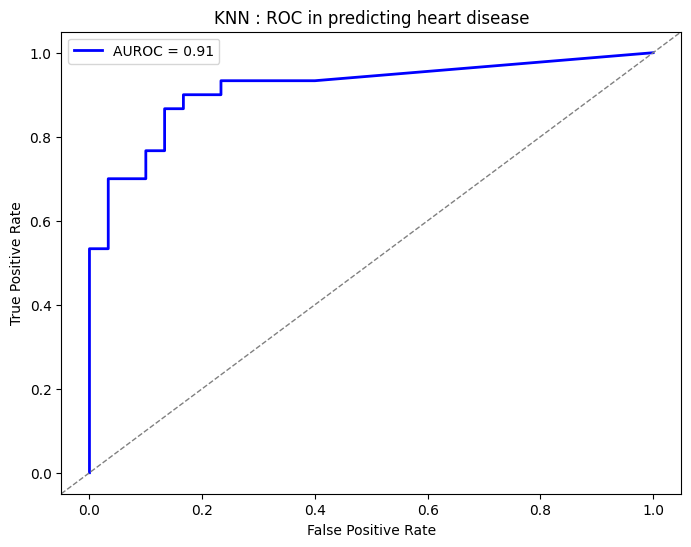

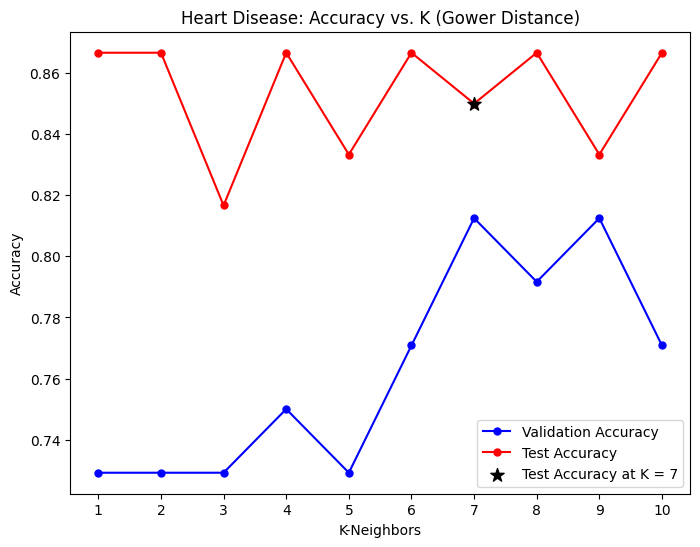

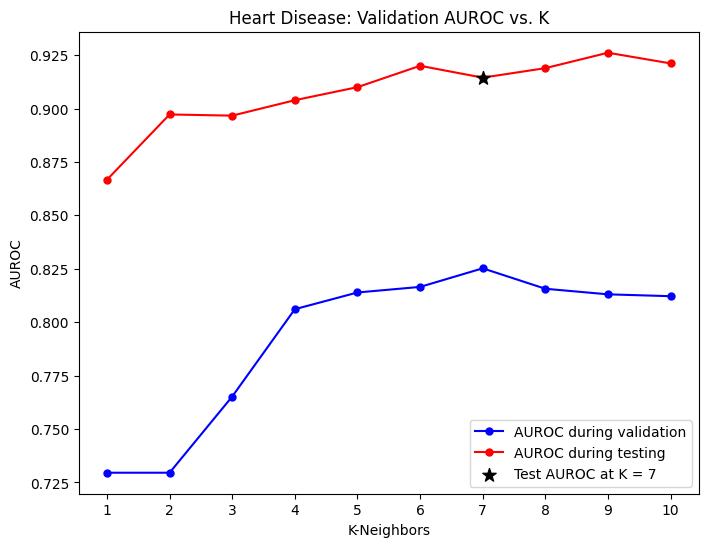

In [28]:
# Define features and target
Heart_features = ["age", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "sex"]
Heart_y, classes = pd.factorize(y_cleaned)

x_cleaned_standardized = x_cleaned_standardized[Heart_features]

# Compute Gower distance matrix
Heart_gower_distances = gower.gower_matrix(x_cleaned_standardized)

# Split data into training+validation and testing sets
train_val_indices, test_indices, Heart_y_train_val, Heart_y_test = train_test_split(
    range(len(Heart_gower_distances)), Heart_y, test_size = 0.2, random_state = 1, shuffle = True
)

# Further split the training+validation set into training and validation sets
train_indices, val_indices, Heart_y_train, Heart_y_val = train_test_split(
    train_val_indices, Heart_y_train_val, test_size = 0.2, random_state = 1, shuffle = True
)

# Extract Gower submatrices for the dataset splits
train_val_distances = Heart_gower_distances[np.ix_(train_val_indices, train_val_indices)]
train_distances = Heart_gower_distances[np.ix_(train_indices, train_indices)]
val_distances = Heart_gower_distances[np.ix_(val_indices, train_indices)]
test_distances = Heart_gower_distances[np.ix_(test_indices, train_val_indices)]

k_values = range(1, 11)
# Hyperparameter tuning with the validation set

validation_accuracies = []
validation_aurocs = []
for k in k_values:
    knn = WeightedKNN(K = k, precomputed = True)  # Initialize with precomputed distances
    knn.fit(train_indices, Heart_y_train)
    val_prediction, val_proba = knn.predict(val_indices, dist_matrix = val_distances)
    val_acc = knn.evaluate_acc(val_prediction, Heart_y_val)
    validation_accuracies.append(val_acc)

    binary_true = (Heart_y_val == 1).astype(int)  # Assuming 1 is the positive class
    fpr, tpr, _ = roc_curve(binary_true, val_proba[:, 1])  # Probabilities for the positive class
    validation_aurocs.append(auc(fpr, tpr))

# Compute test accuracies for all K values
test_accuracies = []
KNN_test_aurocs = []
for k in k_values:
    knn = WeightedKNN(K = k, precomputed = True)
    knn.fit(train_val_indices, Heart_y_train_val)
    test_prediction, test_proba = knn.predict(test_indices, dist_matrix = test_distances)
    test_acc = knn.evaluate_acc(test_prediction, Heart_y_test)
    test_accuracies.append(test_acc)

    # Compute AUROC using roc_curve and auc
    binary_true = (Heart_y_test == 1).astype(int)
    fpr, tpr, _ = roc_curve(binary_true, test_proba[:, 1])
    KNN_test_aurocs.append(auc(fpr, tpr))


# Determine the best K and evaluate on the test set
best_k = k_values[np.argmax(validation_accuracies)]
final_knn = WeightedKNN(K = best_k, precomputed = True)
final_knn.fit(train_val_indices, Heart_y_train_val)  # Train on full training+validation set
test_prediction, final_test_proba = final_knn.predict(test_indices, dist_matrix = test_distances)
test_accuracy = final_knn.evaluate_acc(test_prediction, Heart_y_test)
binary_true = (Heart_y_test == 1).astype(int)
KNN_fpr, KNN_tpr, _ = roc_curve(binary_true, final_test_proba[:, 1])
KNN_final_test_auc = (auc(KNN_fpr, KNN_tpr))


plt.figure(figsize=(8, 6))
plt.clf()
plt.plot(KNN_fpr, KNN_tpr, "b-", lw = 2, label = "AUROC = %0.2f"%KNN_final_test_auc)
plt.axline((0, 0), (1, 1), linestyle = "--", lw = 1, color = 'gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN : ROC in predicting heart disease')
plt.legend(loc = "best")
plt.show()


# Plot validation and test accuracies
plt.figure(figsize = (8, 6))
plt.plot(k_values, validation_accuracies, marker = 'o', color='b', linestyle = '-', markersize = 5, label = "Validation Accuracy")
plt.plot(k_values, test_accuracies, marker = 'o', color = 'r', linestyle = '-', markersize=5, label = "Test Accuracy")
plt.scatter(best_k, test_accuracy, color = 'black', s = 100, marker = "*", label = f'Test Accuracy at K = {best_k}', zorder=5)
plt.title("Heart Disease: Accuracy vs. K (Gower Distance)")
plt.xlabel("K-Neighbors")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.legend(loc = 'best')
plt.show()

# Plot AUROC for validation and testing
plt.figure(figsize=(8, 6))
plt.plot(k_values, validation_aurocs, marker = 'o', color = 'b', linestyle = '-', markersize = 5, label = "AUROC during validation")
plt.plot(k_values, KNN_test_aurocs, marker = 'o', color = 'r', linestyle = '-', markersize = 5, label = "AUROC during testing")
plt.scatter(best_k, KNN_final_test_auc, color = 'black', marker = "*", s = 100, label = f'Test AUROC at K = {best_k}', zorder = 5)
plt.title("Heart Disease: Validation AUROC vs. K")
plt.xlabel("K-Neighbors")
plt.ylabel("AUROC")
plt.xticks(k_values)
plt.legend(loc = 'best')
plt.show()


## Decision tree on the Heart Data set (Gini - Index)

Validation Accuracy at Depth 1: 72.9%
Validation Accuracy at Depth 2: 68.8%
Validation Accuracy at Depth 3: 72.9%
Validation Accuracy at Depth 4: 68.8%
Validation Accuracy at Depth 5: 77.1%
Validation Accuracy at Depth 6: 72.9%
Validation Accuracy at Depth 7: 70.8%
Validation Accuracy at Depth 8: 70.8%
Validation Accuracy at Depth 9: 70.8%
Validation Accuracy at Depth 10: 70.8%
Test Accuracy at Depth 1: 78.3%
Test Accuracy at Depth 2: 73.3%
Test Accuracy at Depth 3: 83.3%
Test Accuracy at Depth 4: 80.0%
Test Accuracy at Depth 5: 78.3%
Test Accuracy at Depth 6: 81.7%
Test Accuracy at Depth 7: 85.0%
Test Accuracy at Depth 8: 85.0%
Test Accuracy at Depth 9: 85.0%
Test Accuracy at Depth 10: 85.0%
Test Accuracy with Depth=5: 0.78


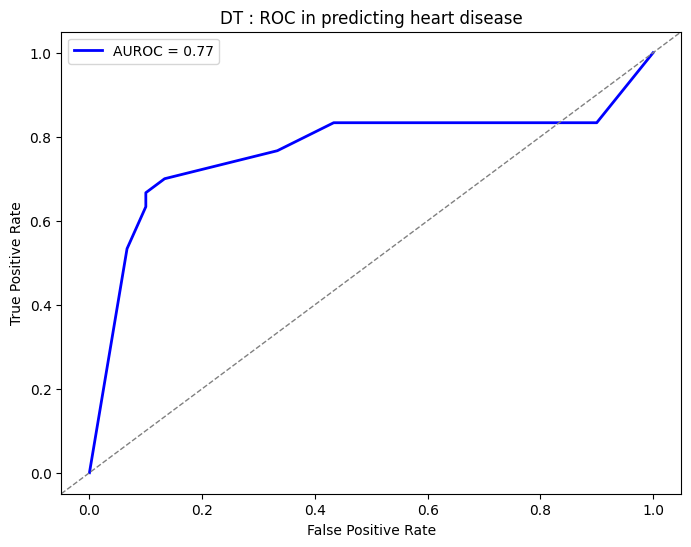

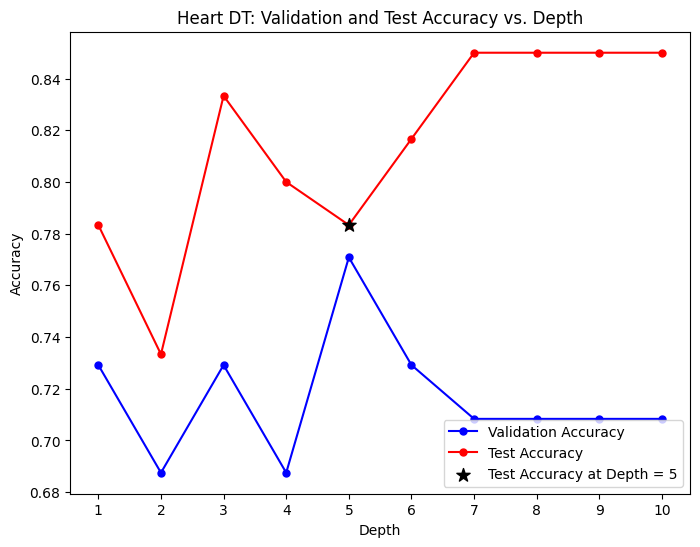

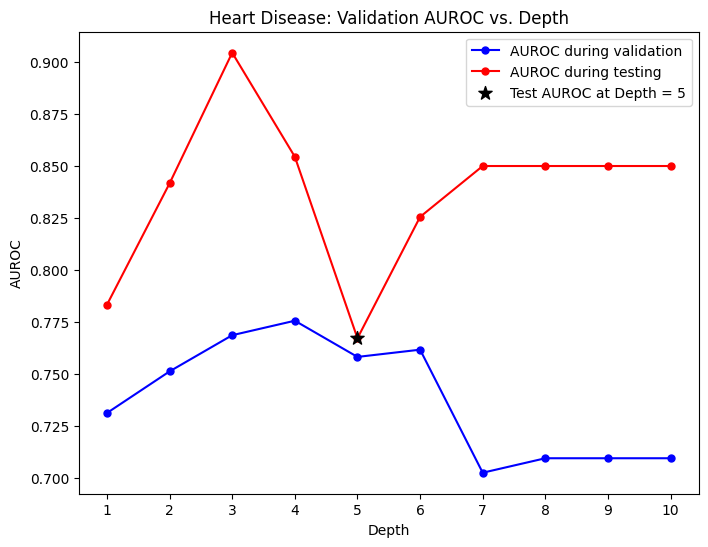

In [29]:
# Split into training+validation and test sets
Heart_X_train_full, Heart_X_test, Heart_y_train_full, Heart_y_test = train_test_split(
    x_cleaned, Heart_y, test_size = 0.2, random_state = 1, shuffle = True
)

# Further split training+validation into training and validation sets
Heart_X_train, Heart_X_val, Heart_y_train, Heart_y_val = train_test_split(
    Heart_X_train_full, Heart_y_train_full, test_size = 0.2, random_state = 1, shuffle = True
)

# Hyperparameter tuning: testing different depths
d_values = range(1, 11)
GI_val_accuracies = []
GI_validation_aurocs = []
for d in d_values:
    tree = DT(max_depth = d, cost_function = cost_gini_index)
    tree.fit(Heart_X_train, Heart_y_train)
    val_predictions, val_proba = tree.predict(Heart_X_val)
    accuracy = np.sum(val_predictions == Heart_y_val) / Heart_y_val.shape[0]
    print(f'Validation Accuracy at Depth {d}: {accuracy * 100:.1f}%')
    GI_val_accuracies.append(accuracy)

    # Compute AUROC using roc_curve and auc
    binary_true = (Heart_y_val == 1).astype(int)  # Assuming 1 is the positive class
    fpr, tpr, _ = roc_curve(binary_true, val_proba[:, 1])  # Probabilities for the positive class
    GI_validation_aurocs.append(auc(fpr, tpr))

# Evaluate test accuracies for all depths
GI_test_accuracies = []
DT_GI_test_aurocs = []
for d in d_values:
    tree = DT(max_depth = d, cost_function = cost_gini_index)
    tree.fit(Heart_X_train_full, Heart_y_train_full)
    test_predictions, test_proba = tree.predict(Heart_X_test)
    test_acc = np.sum(test_predictions == Heart_y_test) / Heart_y_test.shape[0]
    print(f'Test Accuracy at Depth {d}: {test_acc * 100:.1f}%')
    GI_test_accuracies.append(test_acc)

    # Compute AUROC using roc_curve and auc
    binary_true = (Heart_y_test == 1).astype(int)
    fpr, tpr, _ = roc_curve(binary_true, test_proba[:, 1])
    DT_GI_test_aurocs.append(auc(fpr, tpr))


# Select the best depth based on validation accuracy
GI_best_d = d_values[np.argmax(GI_val_accuracies)]
# Train the final model with the best depth on the full training set
HD_GI_final_tree = DT(max_depth = GI_best_d, cost_function = cost_gini_index)
HD_GI_final_tree.fit(Heart_X_train_full, Heart_y_train_full)
final_predictions, final_test_proba = HD_GI_final_tree.predict(Heart_X_test)
GI_final_accuracy = np.sum(final_predictions == Heart_y_test) / Heart_y_test.shape[0]
print(f"Test Accuracy with Depth={GI_best_d}: {GI_final_accuracy:.2f}")

binary_true = (Heart_y_test == 1).astype(int)
DT_GI_fpr, DT_GI_tpr, _ = roc_curve(binary_true, final_test_proba[:, 1])
DT_GI_final_test_auc = (auc(DT_GI_fpr, DT_GI_tpr))


plt.figure(figsize=(8, 6))
plt.clf()
plt.plot(DT_GI_fpr, DT_GI_tpr, "b-", lw = 2, label = "AUROC = %0.2f"%DT_GI_final_test_auc)
plt.axline((0, 0), (1, 1), linestyle = "--", lw = 1, color = 'gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DT : ROC in predicting heart disease')
plt.legend(loc = "best")
plt.show()

# Plot validation and test accuracies
plt.figure(figsize = (8, 6))
plt.plot(d_values, GI_val_accuracies, marker = 'o', color = 'b', linestyle = '-', markersize = 5, label = "Validation Accuracy")
plt.plot(d_values, GI_test_accuracies, marker = 'o', color = 'r', linestyle = '-', markersize = 5, label = "Test Accuracy")
plt.scatter(GI_best_d, GI_final_accuracy, color = 'black', marker = "*", s = 100, label = f'Test Accuracy at Depth = {GI_best_d}', zorder = 5)
plt.xticks(d_values)
plt.legend(loc = 'best')
plt.title("Heart DT: Validation and Test Accuracy vs. Depth")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.show()

# Plot AUROC for validation and testing
plt.figure(figsize=(8, 6))
plt.plot(d_values, GI_validation_aurocs, marker = 'o', color = 'b', linestyle = '-', markersize = 5, label = "AUROC during validation")
plt.plot(d_values, DT_GI_test_aurocs, marker = 'o', color = 'r', linestyle = '-', markersize = 5, label = "AUROC during testing")
plt.scatter(GI_best_d, DT_GI_final_test_auc, color = 'black', marker = "*", s = 100, label = f'Test AUROC at Depth = {GI_best_d}', zorder = 5)
plt.title("Heart Disease: Validation AUROC vs. Depth")
plt.xlabel("Depth")
plt.ylabel("AUROC")
plt.xticks(d_values)
plt.legend(loc = 'best')
plt.show()



## DT on heart dataset (Entropy cost)

Validation Accuracy at Depth 1: 72.9%
Validation Accuracy at Depth 2: 68.8%
Validation Accuracy at Depth 3: 72.9%
Validation Accuracy at Depth 4: 68.8%
Validation Accuracy at Depth 5: 75.0%
Validation Accuracy at Depth 6: 75.0%
Validation Accuracy at Depth 7: 72.9%
Validation Accuracy at Depth 8: 68.8%
Validation Accuracy at Depth 9: 68.8%
Validation Accuracy at Depth 10: 68.8%
Test Accuracy at Depth 1: 78.3%
Test Accuracy at Depth 2: 73.3%
Test Accuracy at Depth 3: 81.7%
Test Accuracy at Depth 4: 80.0%
Test Accuracy at Depth 5: 80.0%
Test Accuracy at Depth 6: 75.0%
Test Accuracy at Depth 7: 78.3%
Test Accuracy at Depth 8: 80.0%
Test Accuracy at Depth 9: 78.3%
Test Accuracy at Depth 10: 78.3%
Test Accuracy with Depth=5: 0.80


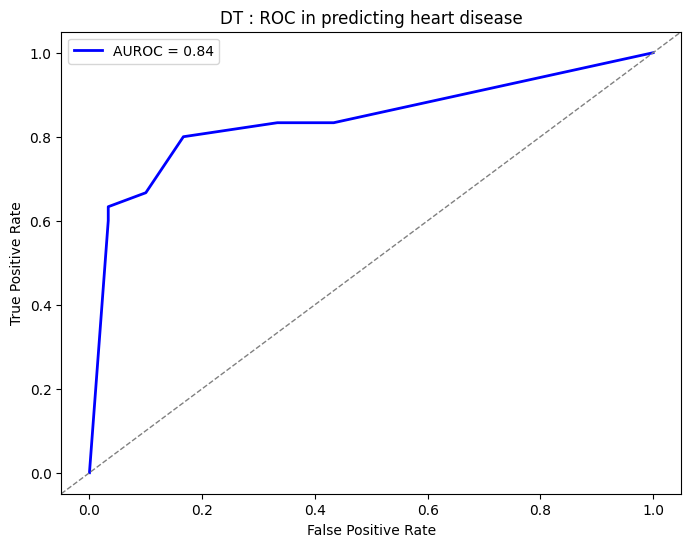

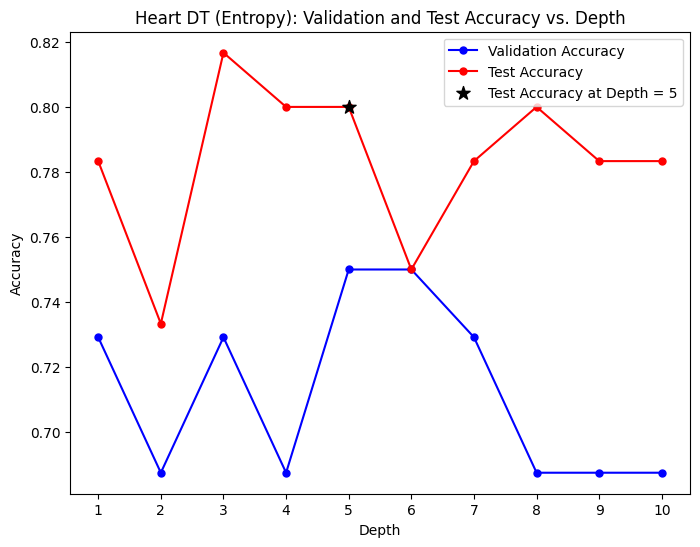

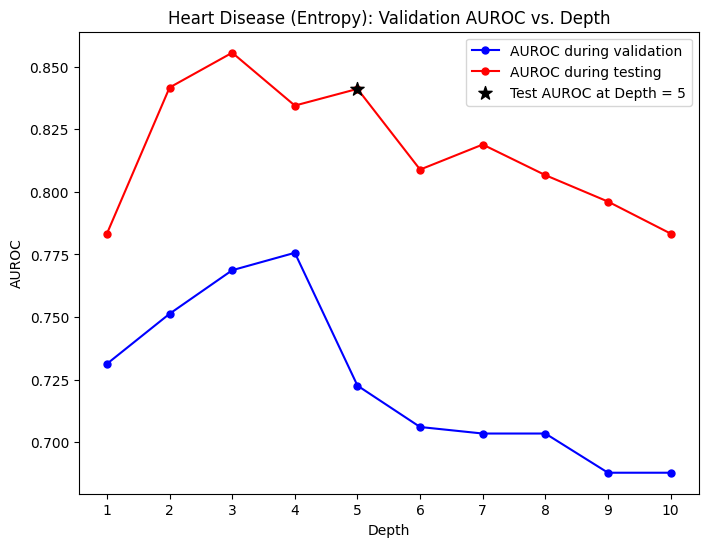

In [30]:
# Hyperparameter tuning: testing different depths
EN_val_accuracies = []
EN_validation_aurocs = []
for d in d_values:
    tree = DT(max_depth = d, cost_function = cost_entropy)  # Updated to cost_entropy
    tree.fit(Heart_X_train, Heart_y_train)
    val_predictions, val_proba = tree.predict(Heart_X_val)
    accuracy = np.sum(val_predictions == Heart_y_val) / Heart_y_val.shape[0]
    print(f'Validation Accuracy at Depth {d}: {accuracy * 100:.1f}%')
    EN_val_accuracies.append(accuracy)

    # Compute AUROC using roc_curve and auc
    binary_true = (Heart_y_val == 1).astype(int)  # Assuming 1 is the positive class
    fpr, tpr, _ = roc_curve(binary_true, val_proba[:, 1])  # Probabilities for the positive class
    EN_validation_aurocs.append(auc(fpr, tpr))

# Evaluate test accuracies for all depths
EN_test_accuracies = []
DT_EN_test_aurocs = []
for d in d_values:
    tree = DT(max_depth = d, cost_function = cost_entropy)  # Updated to cost_entropy
    tree.fit(Heart_X_train_full, Heart_y_train_full)
    test_predictions, test_proba = tree.predict(Heart_X_test)
    test_acc = np.sum(test_predictions == Heart_y_test) / Heart_y_test.shape[0]
    print(f'Test Accuracy at Depth {d}: {test_acc * 100:.1f}%')
    EN_test_accuracies.append(test_acc)

    # Compute AUROC using roc_curve and auc
    binary_true = (Heart_y_test == 1).astype(int)
    fpr, tpr, _ = roc_curve(binary_true, test_proba[:, 1])
    DT_EN_test_aurocs.append(auc(fpr, tpr))


# Select the best depth based on validation accuracy
EN_best_d = d_values[np.argmax(EN_val_accuracies)]
# Train the final model with the best depth on the full training set
HD_EN_final_tree = DT(max_depth = EN_best_d, cost_function = cost_entropy)  # Updated to cost_entropy
HD_EN_final_tree.fit(Heart_X_train_full, Heart_y_train_full)
final_predictions, final_test_proba = HD_EN_final_tree.predict(Heart_X_test)
EN_final_accuracy = np.sum(final_predictions == Heart_y_test) / Heart_y_test.shape[0]
print(f"Test Accuracy with Depth={EN_best_d}: {EN_final_accuracy:.2f}")

binary_true = (Heart_y_test == 1).astype(int)
DT_EN_fpr, DT_EN_tpr, _ = roc_curve(binary_true, final_test_proba[:, 1])
DT_EN_final_test_auc = (auc(DT_EN_fpr, DT_EN_tpr))


plt.figure(figsize=(8, 6))
plt.clf()
plt.plot(DT_EN_fpr, DT_EN_tpr, "b-", lw = 2, label = "AUROC = %0.2f"%DT_EN_final_test_auc)
plt.axline((0, 0), (1, 1), linestyle = "--", lw = 1, color = 'gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DT : ROC in predicting heart disease')
plt.legend(loc = "best")
plt.show()

# Plot validation and test accuracies
plt.figure(figsize = (8, 6))
plt.plot(d_values, EN_val_accuracies, marker = 'o', color = 'b', linestyle = '-', markersize = 5, label = "Validation Accuracy")
plt.plot(d_values, EN_test_accuracies, marker = 'o', color = 'r', linestyle = '-', markersize = 5, label = "Test Accuracy")
plt.scatter(EN_best_d, EN_final_accuracy, color = 'black', marker = "*", s = 100, label = f'Test Accuracy at Depth = {EN_best_d}', zorder = 5)
plt.xticks(d_values)
plt.legend(loc = 'best')
plt.title("Heart DT (Entropy): Validation and Test Accuracy vs. Depth")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.show()

# Plot AUROC for validation and testing
plt.figure(figsize=(8, 6))
plt.plot(d_values, EN_validation_aurocs, marker = 'o', color = 'b', linestyle = '-', markersize = 5, label = "AUROC during validation")
plt.plot(d_values, DT_EN_test_aurocs, marker = 'o', color = 'r', linestyle = '-', markersize = 5, label = "AUROC during testing")
plt.scatter(EN_best_d, DT_EN_final_test_auc, color = 'black', marker = "*", s = 100, label = f'Test AUROC at Depth = {EN_best_d}', zorder = 5)
plt.title("Heart Disease (Entropy): Validation AUROC vs. Depth")
plt.xlabel("Depth")
plt.ylabel("AUROC")
plt.xticks(d_values)
plt.legend(loc = 'best')
plt.show()


## DT on heart dataset (Misclassification)

Validation Accuracy at Depth 1: 72.9%
Validation Accuracy at Depth 2: 64.6%
Validation Accuracy at Depth 3: 64.6%
Validation Accuracy at Depth 4: 68.8%
Validation Accuracy at Depth 5: 68.8%
Validation Accuracy at Depth 6: 68.8%
Validation Accuracy at Depth 7: 66.7%
Validation Accuracy at Depth 8: 66.7%
Validation Accuracy at Depth 9: 66.7%
Validation Accuracy at Depth 10: 66.7%
Test Accuracy at Depth 1: 78.3%
Test Accuracy at Depth 2: 78.3%
Test Accuracy at Depth 3: 76.7%
Test Accuracy at Depth 4: 76.7%
Test Accuracy at Depth 5: 76.7%
Test Accuracy at Depth 6: 76.7%
Test Accuracy at Depth 7: 76.7%
Test Accuracy at Depth 8: 75.0%
Test Accuracy at Depth 9: 73.3%
Test Accuracy at Depth 10: 76.7%
Test Accuracy with Depth=1: 0.78


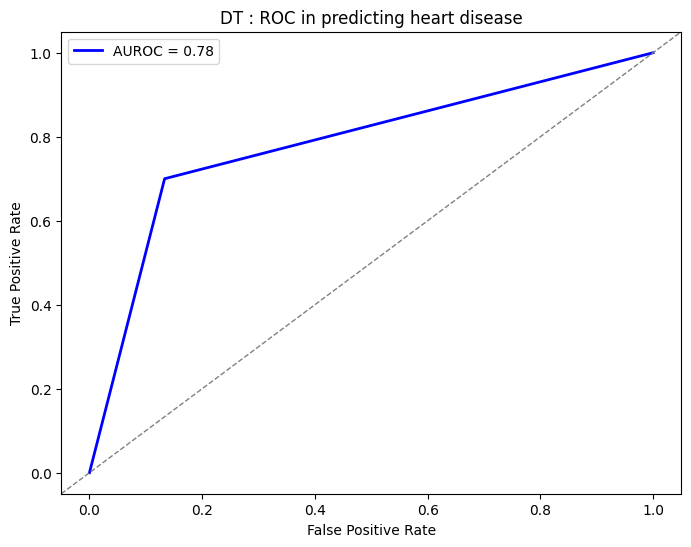

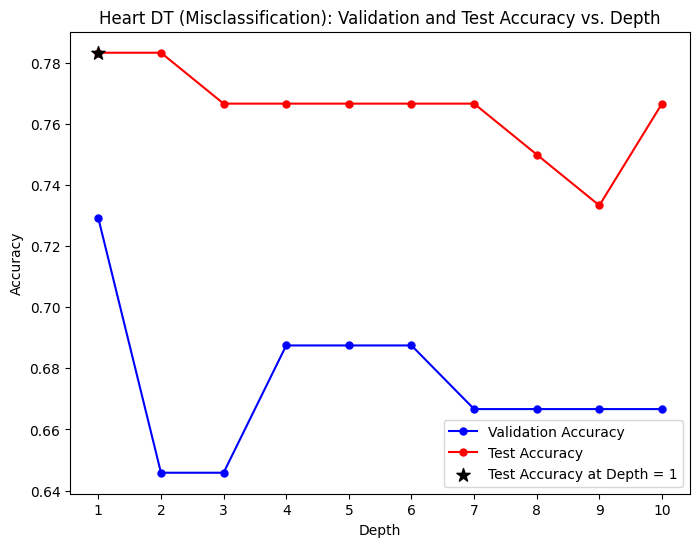

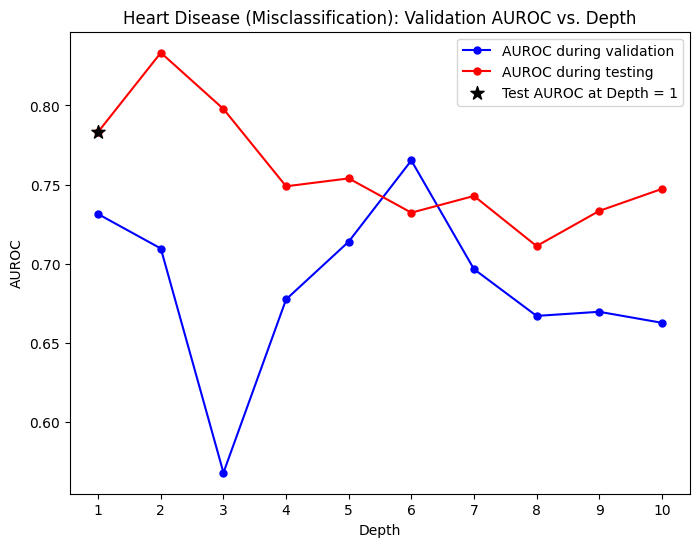

In [31]:
# Hyperparameter tuning: testing different depths
MC_val_accuracies = []
MC_validation_aurocs = []
for d in d_values:
    tree = DT(max_depth = d, cost_function = cost_misclassification)  # Updated to cost_misclassification
    tree.fit(Heart_X_train, Heart_y_train)
    val_predictions, val_proba = tree.predict(Heart_X_val)
    accuracy = np.sum(val_predictions == Heart_y_val) / Heart_y_val.shape[0]
    print(f'Validation Accuracy at Depth {d}: {accuracy * 100:.1f}%')
    MC_val_accuracies.append(accuracy)

    # Compute AUROC using roc_curve and auc
    binary_true = (Heart_y_val == 1).astype(int)  # Assuming 1 is the positive class
    fpr, tpr, _ = roc_curve(binary_true, val_proba[:, 1])  # Probabilities for the positive class
    MC_validation_aurocs.append(auc(fpr, tpr))

# Evaluate test accuracies for all depths
MC_test_accuracies = []
DT_MC_test_aurocs = []
for d in d_values:
    tree = DT(max_depth = d, cost_function = cost_misclassification)  # Updated to cost_misclassification
    tree.fit(Heart_X_train_full, Heart_y_train_full)
    test_predictions, test_proba = tree.predict(Heart_X_test)
    test_acc = np.sum(test_predictions == Heart_y_test) / Heart_y_test.shape[0]
    print(f'Test Accuracy at Depth {d}: {test_acc * 100:.1f}%')
    MC_test_accuracies.append(test_acc)

    # Compute AUROC using roc_curve and auc
    binary_true = (Heart_y_test == 1).astype(int)
    fpr, tpr, _ = roc_curve(binary_true, test_proba[:, 1])
    DT_MC_test_aurocs.append(auc(fpr, tpr))


# Select the best depth based on validation accuracy
MC_best_d = d_values[np.argmax(MC_val_accuracies)]
# Train the final model with the best depth on the full training set
HD_MC_final_tree = DT(max_depth = MC_best_d, cost_function = cost_misclassification)  # Updated to cost_misclassification
HD_MC_final_tree.fit(Heart_X_train_full, Heart_y_train_full)
final_predictions, final_test_proba = HD_MC_final_tree.predict(Heart_X_test)
MC_final_accuracy = np.sum(final_predictions == Heart_y_test) / Heart_y_test.shape[0]
print(f"Test Accuracy with Depth={MC_best_d}: {MC_final_accuracy:.2f}")

binary_true = (Heart_y_test == 1).astype(int)
DT_MC_fpr, DT_MC_tpr, _ = roc_curve(binary_true, final_test_proba[:, 1])
DT_MC_final_test_auc = (auc(DT_MC_fpr, DT_MC_tpr))


plt.figure(figsize=(8, 6))
plt.clf()
plt.plot(DT_MC_fpr, DT_MC_tpr, "b-", lw = 2, label = "AUROC = %0.2f"%DT_MC_final_test_auc)
plt.axline((0, 0), (1, 1), linestyle = "--", lw = 1, color = 'gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DT : ROC in predicting heart disease')
plt.legend(loc = "best")
plt.show()

# Plot validation and test accuracies
plt.figure(figsize = (8, 6))
plt.plot(d_values, MC_val_accuracies, marker = 'o', color = 'b', linestyle = '-', markersize = 5, label = "Validation Accuracy")
plt.plot(d_values, MC_test_accuracies, marker = 'o', color = 'r', linestyle = '-', markersize = 5, label = "Test Accuracy")
plt.scatter(MC_best_d, MC_final_accuracy, color = 'black', marker = "*", s = 100, label = f'Test Accuracy at Depth = {MC_best_d}', zorder = 5)
plt.xticks(d_values)
plt.legend(loc = 'best')
plt.title("Heart DT (Misclassification): Validation and Test Accuracy vs. Depth")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.show()

# Plot AUROC for validation and testing
plt.figure(figsize=(8, 6))
plt.plot(d_values, MC_validation_aurocs, marker = 'o', color = 'b', linestyle = '-', markersize = 5, label = "AUROC during validation")
plt.plot(d_values, DT_MC_test_aurocs, marker = 'o', color = 'r', linestyle = '-', markersize = 5, label = "AUROC during testing")
plt.scatter(MC_best_d, DT_MC_final_test_auc, color = 'black', marker = "*", s = 100, label = f'Test AUROC at Depth = {MC_best_d}', zorder = 5)
plt.title("Heart Disease (Misclassification): Validation AUROC vs. Depth")
plt.xlabel("Depth")
plt.ylabel("AUROC")
plt.xticks(d_values)
plt.legend(loc = 'best')
plt.show()


## Comparing Test accuracies for Heart data using different costs

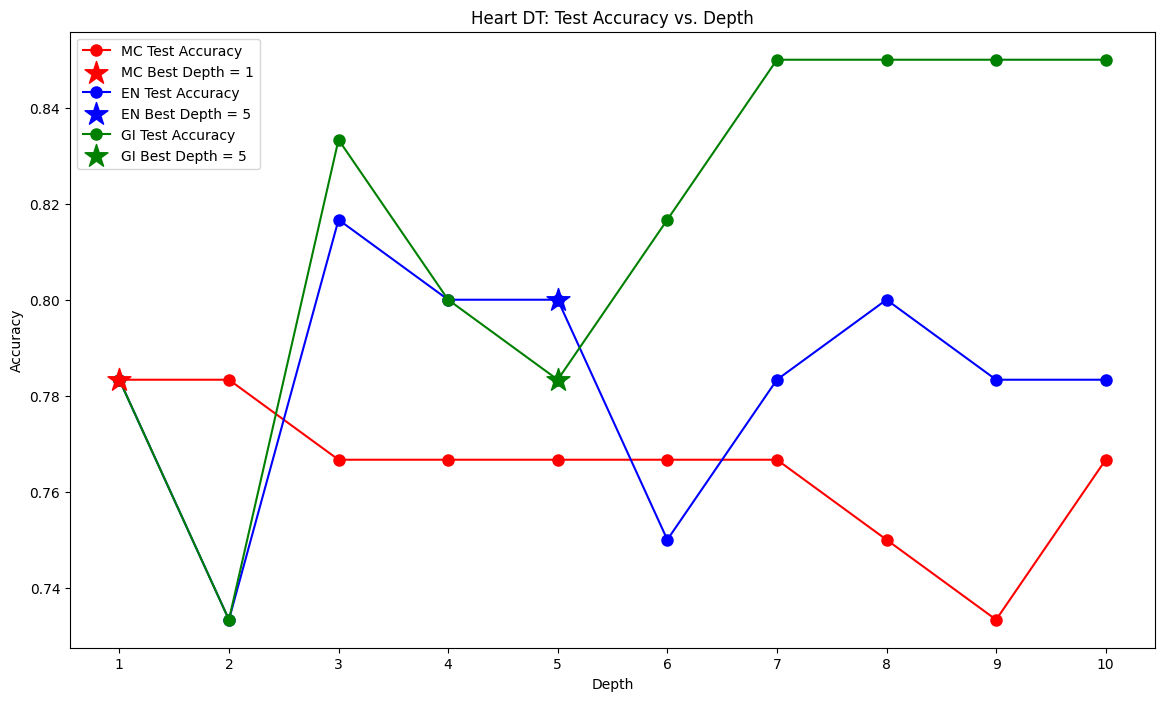

In [32]:
plt.figure(figsize = (14, 8))

plt.plot(d_values, MC_test_accuracies, marker = 'o', color = 'r', linestyle = '-', markersize = 8, label = "MC Test Accuracy")
plt.scatter(MC_best_d, MC_final_accuracy, color = 'r', marker = "*", s = 300, label = f'MC Best Depth = {MC_best_d}', zorder = 5)

plt.plot(d_values, EN_test_accuracies, marker = 'o', color = 'b', linestyle = '-', markersize = 8, label = "EN Test Accuracy")
plt.scatter(EN_best_d, EN_final_accuracy, color = 'b', marker = "*", s = 300, label = f'EN Best Depth = {EN_best_d}', zorder = 5)

plt.plot(d_values, GI_test_accuracies, marker = 'o', color = 'g', linestyle = '-', markersize = 8, label = "GI Test Accuracy")
plt.scatter(GI_best_d, GI_final_accuracy, color = 'g', marker = "*", s = 300, label = f'GI Best Depth = {GI_best_d}', zorder = 5)


plt.xticks(d_values)
plt.legend(loc = 'best')
plt.title("Heart DT: Test Accuracy vs. Depth")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.show()


## Comparing AUROC using different costs for DT

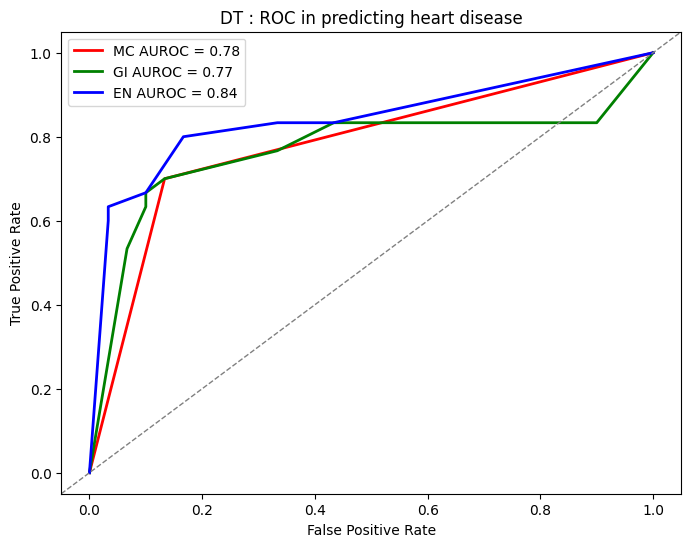

In [33]:
plt.figure(figsize=(8, 6))
plt.clf()
plt.plot(DT_MC_fpr, DT_MC_tpr, "r-", lw = 2, label = "MC AUROC = %0.2f"%DT_MC_final_test_auc)
plt.plot(DT_GI_fpr, DT_GI_tpr, "g-", lw = 2, label = "GI AUROC = %0.2f"%DT_GI_final_test_auc)
plt.plot(DT_EN_fpr, DT_EN_tpr, "b-", lw = 2, label = "EN AUROC = %0.2f"%DT_EN_final_test_auc)
plt.axline((0, 0), (1, 1), linestyle = "--", lw = 1, color = 'gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DT : ROC in predicting heart disease')
plt.legend(loc = "best")
plt.show()


## AUROC of KNN vs. DT

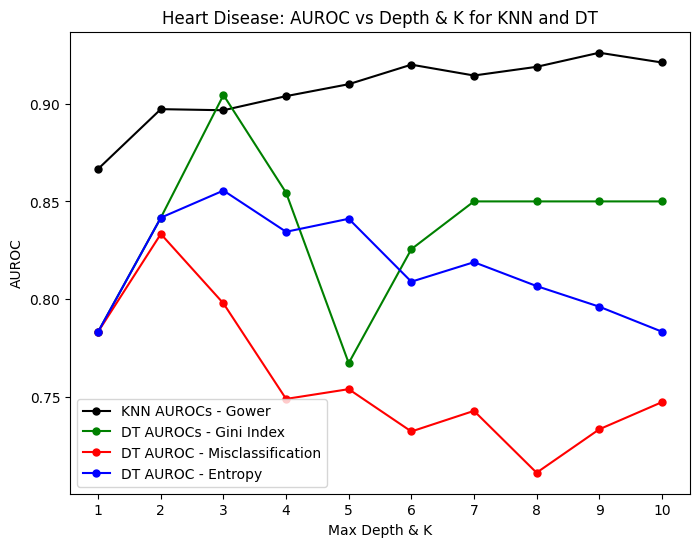

In [34]:
values = range(1,11)
plt.figure(figsize=(8, 6))
plt.plot(values, KNN_test_aurocs, marker = 'o', color = 'k', linestyle = '-', markersize = 5, label = "KNN AUROCs - Gower")
plt.plot(values, DT_GI_test_aurocs, marker = 'o', color = 'g', linestyle = '-', markersize = 5, label = "DT AUROCs - Gini Index")
plt.plot(d_values, DT_MC_test_aurocs, marker = 'o', color = 'r', linestyle = '-', markersize = 5, label = "DT AUROC - Misclassification")
plt.plot(d_values, DT_EN_test_aurocs, marker = 'o', color = 'b', linestyle = '-', markersize = 5, label = "DT AUROC - Entropy")
plt.title("Heart Disease: AUROC vs Depth & K for KNN and DT")
plt.xlabel("Max Depth & K")
plt.ylabel("AUROC")
plt.xticks(values)
plt.legend(loc = 'best')
plt.show()

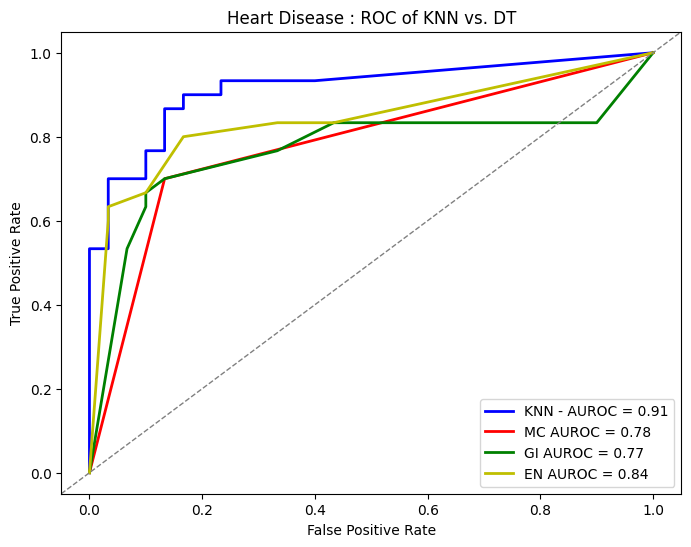

In [35]:
plt.figure(figsize=(8, 6))
plt.clf()
plt.plot(KNN_fpr, KNN_tpr, "b-", lw = 2, label = "KNN - AUROC = %0.2f"%KNN_final_test_auc)
plt.plot(DT_MC_fpr, DT_MC_tpr, "r-", lw = 2, label = "MC AUROC = %0.2f"%DT_MC_final_test_auc)
plt.plot(DT_GI_fpr, DT_GI_tpr, "g-", lw = 2, label = "GI AUROC = %0.2f"%DT_GI_final_test_auc)
plt.plot(DT_EN_fpr, DT_EN_tpr, "y-", lw = 2, label = "EN AUROC = %0.2f"%DT_EN_final_test_auc)
plt.axline((0, 0), (1, 1), linestyle = "--", lw = 1, color = 'gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Heart Disease : ROC of KNN vs. DT')
plt.legend(loc = "best")
plt.show()



# Feature ranking

In [36]:
def compute_feature_importance(tree):
    feature_counts = np.zeros(tree.data.shape[1])  # Initialize array for feature counts

    def traverse(node):
        if node is None or node.split_feature is None:
            return
        feature_counts[node.split_feature] += 1
        traverse(node.left)
        traverse(node.right)

    traverse(tree.root)
    return feature_counts

# Define tree models and their corresponding datasets
trees = {
    "Penguin - Gini Index": GI_final_tree,
    "Penguin - Entropy": EN_final_tree,
    "Penguin - Misclassification": MC_final_tree,
    "Heart Disease - Gini Index": HD_GI_final_tree,
    "Heart Disease - Entropy": HD_EN_final_tree,
    "Heart Disease - Misclassification": HD_MC_final_tree
}

datasets = {
    "Penguin - Gini Index": penguin_X_train_full,
    "Penguin - Entropy": penguin_X_train_full,
    "Penguin - Misclassification": penguin_X_train_full,
    "Heart Disease - Gini Index": Heart_X_train_full,
    "Heart Disease - Entropy": Heart_X_train_full,
    "Heart Disease - Misclassification": Heart_X_train_full
}

# Loop through each tree, compute importance, and display results
for name, tree in trees.items():
    feature_importance_counts = compute_feature_importance(tree)

    # Create a DataFrame for visualization
    feature_importance_df = pd.DataFrame({
        "Feature": datasets[name].columns,
        "Importance_Score": feature_importance_counts
    }).sort_values(by="Importance_Score", ascending=False)

    # Print the top 5 important features
    print(f"\nTop 5 Important Features ({name}):")
    print(feature_importance_df.head(5))


Top 5 Important Features (Penguin - Gini Index):
             Feature  Importance_Score
0   culmen_length_mm               1.0
1    culmen_depth_mm               1.0
2  flipper_length_mm               1.0
3        body_mass_g               0.0

Top 5 Important Features (Penguin - Entropy):
             Feature  Importance_Score
0   culmen_length_mm               1.0
1    culmen_depth_mm               1.0
2  flipper_length_mm               1.0
3        body_mass_g               0.0

Top 5 Important Features (Penguin - Misclassification):
             Feature  Importance_Score
0   culmen_length_mm               1.0
1    culmen_depth_mm               1.0
2  flipper_length_mm               1.0
3        body_mass_g               0.0

Top 5 Important Features (Heart Disease - Gini Index):
   Feature  Importance_Score
0      age              10.0
9  oldpeak               6.0
4     chol               3.0
1      sex               2.0
2       cp               2.0

Top 5 Important Features (Hear

# Feature Selection Experimentation (Heart Disease)

In [37]:
# Separating the features by variable type
Heart_features = ["age", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "sex"]
numerical_variables = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
categorical_variables = ['cp', 'restecg', 'slope', 'thal']
binary_variables = ['sex', 'fbs', 'exang']

# Scaling and standardizing the numerical variables
scaler_hd = StandardScaler()
x_standardized = pd.DataFrame(
    scaler_hd.fit_transform(x_cleaned[numerical_variables]),
    columns = numerical_variables
)

# Encoding the categorical variables
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

x_encoded = pd.DataFrame(
    encoder.fit_transform(x_cleaned[categorical_variables]),
    columns=encoder.get_feature_names_out(categorical_variables)
)

# Reindexing to combine all the columns
x_cleaned = x_cleaned.reset_index(drop=True)

# Combining all columns
x_binary = x_cleaned[binary_variables]
x_cleaned_standardized_encoded = pd.concat([x_standardized, x_encoded, x_binary], axis=1)

In [38]:
# Add target back to standardized data
x_cleaned_standardized_encoded['target'] = y_cleaned.values

# Calculate group means
group_means_standardized = x_cleaned_standardized_encoded.groupby('target').mean()

# Calculate squared differences of means
squared_differences_std = (
    group_means_standardized.diff().iloc[-1] ** 2
).sort_values(ascending=False)

print("Group Means (Standardized):")
print(group_means_standardized)
print("\nRanked Features by Squared Difference of Means (Standardized):")
print(squared_differences_std)

# Using a threshold of 0.1 (which is quite flexible), we can drop:
# trestbps
# cp_3
# sex
# cp_2
# restecg_0
# chol
# restecg_2
# thal_6.0
# cp_1
# slope_3
# restecg_1
# fbs

Group Means (Standardized):
             age  trestbps      chol   thalach   oldpeak        ca      cp_1  \
target                                                                         
0      -0.210121 -0.142030 -0.074291  0.392174 -0.392391 -0.428606  0.100000   
1       0.245397  0.165875  0.086763 -0.458013  0.458267  0.500562  0.051095   

            cp_2      cp_3      cp_4  ...  restecg_2   slope_1   slope_2  \
target                                ...                                  
0       0.250000  0.406250  0.243750  ...   0.418750  0.643750  0.300000   
1       0.065693  0.131387  0.751825  ...   0.576642  0.262774  0.649635   

         slope_3  thal_3.0  thal_6.0  thal_7.0       sex       fbs     exang  
target                                                                        
0       0.056250  0.793750  0.037500  0.168750  0.556250  0.143750  0.143750  
1       0.087591  0.270073  0.087591  0.642336  0.817518  0.145985  0.540146  

[2 rows x 22 columns]

Ranked

In [39]:
# Ranking the correlation of each feature with the target
# Taking abs because we want to evaluate dependence, not the direction of the relationship
correlation_matrix = x_cleaned_standardized_encoded.corr()

print(correlation_matrix['target'].abs().sort_values(ascending=False))

# Using a threshold of 0.3 (which is again flexible since 0.3 := moderate/weak correlation), we can drop:
# cp_3
# sex
# cp_2
# age
# restecg_0
# restecg_2
# trestbps
# thal_6.0
# cp_1
# chol
# restecg_1
# slope_3
# fbs

target       1.000000
thal_3.0     0.524972
cp_4         0.507035
thal_7.0     0.484657
ca           0.463189
oldpeak      0.424052
thalach      0.423817
exang        0.421355
slope_1      0.380612
slope_2      0.349635
cp_3         0.305345
sex          0.278467
cp_2         0.247535
age          0.227075
restecg_0    0.173028
restecg_2    0.157440
trestbps     0.153490
thal_6.0     0.104651
cp_1         0.091208
chol         0.080285
restecg_1    0.067672
slope_3      0.060950
fbs          0.003167
Name: target, dtype: float64


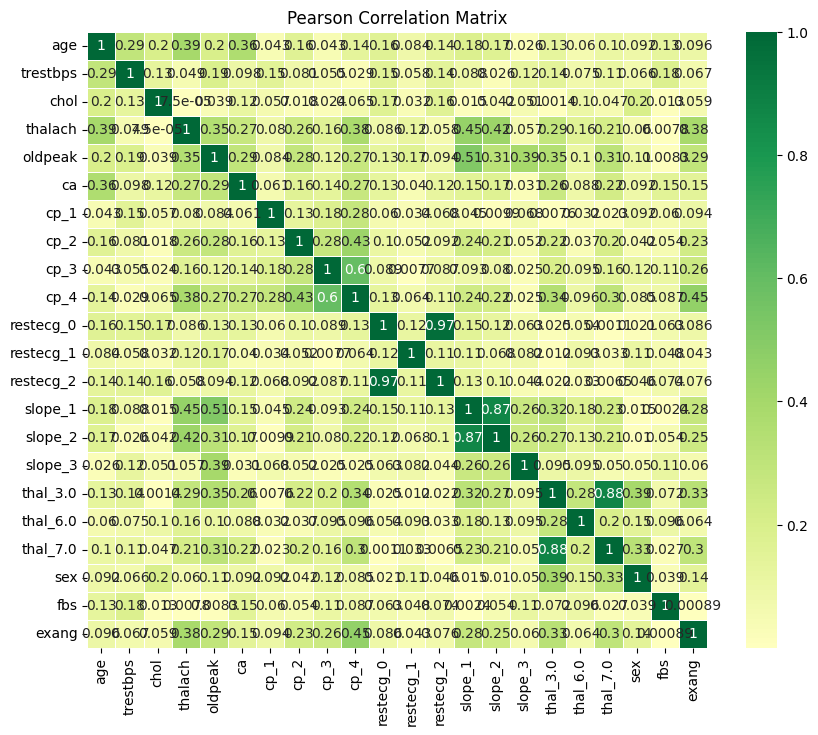

In [40]:
# Computing the correlation between the features to check for multicollinearity
import seaborn as sns

x_cleaned_standardized_wo_target = x_cleaned_standardized_encoded.drop(columns=['target'])

pearson_matrix = x_cleaned_standardized_wo_target.corr(method='pearson')
pearson_matrix = pearson_matrix.abs()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_matrix, annot=True, cmap='RdYlGn', center=0, linewidths=0.5)

plt.title('Pearson Correlation Matrix')
plt.show()

# High correlation (> 0.5) between cp_3 and cp_4, restecg_0 and restecg_2, slope_1 and slope_2, and thal_3.0 and thal_7.0
# Consider dropping cp_3, slope_2, and thal_7.0 because they have a lower predictive power than cp_4, slope_1, and thal_3.0, respectively

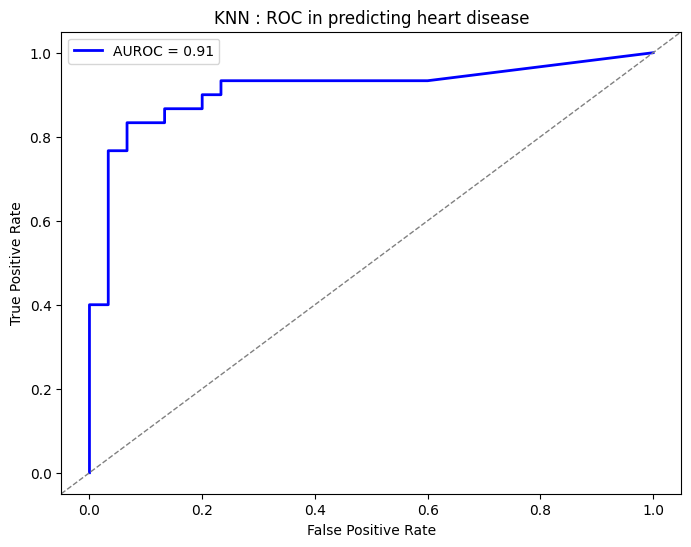

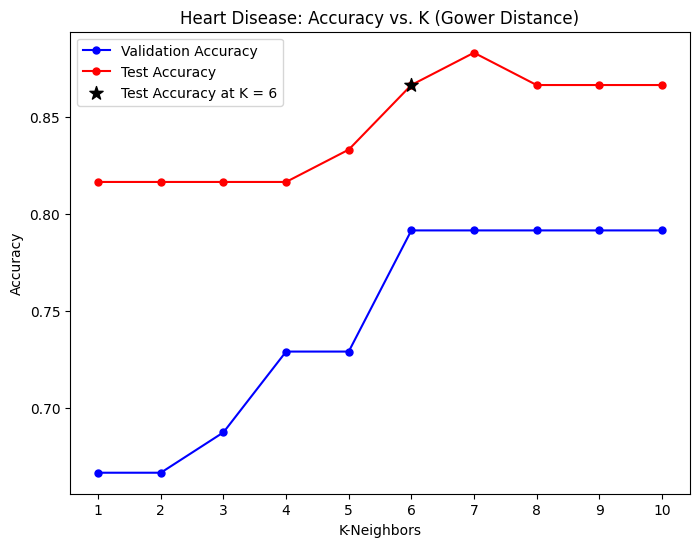

Validation Accuracies:
K = 1: 66.67%
K = 2: 66.67%
K = 3: 68.75%
K = 4: 72.92%
K = 5: 72.92%
K = 6: 79.17%
K = 7: 79.17%
K = 8: 79.17%
K = 9: 79.17%
K = 10: 79.17%

Test Accuracies:
K = 1: 81.67%
K = 2: 81.67%
K = 3: 81.67%
K = 4: 81.67%
K = 5: 83.33%
K = 6: 86.67%
K = 7: 88.33%
K = 8: 86.67%
K = 9: 86.67%
K = 10: 86.67%


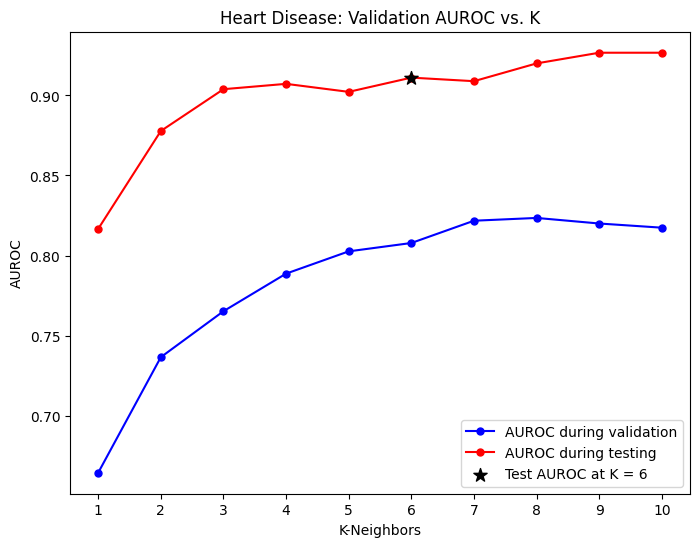

In [41]:
# Define features and target
Heart_features = ['thal_3.0', 'cp_4', 'ca', 'oldpeak', 'thalach', 'exang', 'slope_1']

Heart_y, classes = pd.factorize(y_cleaned)

# Compute Gower distance matrix
Heart_gower_distances = gower.gower_matrix(x_cleaned_standardized_encoded[Heart_features])

# Split data into training+validation and testing sets
train_val_indices, test_indices, Heart_y_train_val, Heart_y_test = train_test_split(
    range(len(x_cleaned_standardized_encoded)), Heart_y, test_size = 0.2, random_state = 1, shuffle = True
)

# Further split the training+validation set into training and validation sets
train_indices, val_indices, Heart_y_train, Heart_y_val = train_test_split(
    train_val_indices, Heart_y_train_val, test_size = 0.2, random_state = 1, shuffle = True
)

# Extract Gower submatrices for the dataset splits
train_val_distances = Heart_gower_distances[np.ix_(train_val_indices, train_val_indices)]
train_distances = Heart_gower_distances[np.ix_(train_indices, train_indices)]
val_distances = Heart_gower_distances[np.ix_(val_indices, train_indices)]
test_distances = Heart_gower_distances[np.ix_(test_indices, train_val_indices)]

k_values = range(1, 11)
# Hyperparameter tuning with the validation set

validation_accuracies = []
validation_aurocs = []
for k in k_values:
    knn = WeightedKNN(K = k, precomputed = True)  # Initialize with precomputed distances
    knn.fit(train_indices, Heart_y_train)
    val_prediction, val_proba = knn.predict(val_indices, dist_matrix = val_distances)
    val_acc = knn.evaluate_acc(val_prediction, Heart_y_val)
    validation_accuracies.append(val_acc)

    binary_true = (Heart_y_val == 1).astype(int)  # Assuming 1 is the positive class
    fpr, tpr, _ = roc_curve(binary_true, val_proba[:, 1])  # Probabilities for the positive class
    validation_aurocs.append(auc(fpr, tpr))

# Compute test accuracies for all K values
test_accuracies = []
KNN_test_aurocs = []
for k in k_values:
    knn = WeightedKNN(K = k, precomputed = True)
    knn.fit(train_val_indices, Heart_y_train_val)
    test_prediction, test_proba = knn.predict(test_indices, dist_matrix = test_distances)
    test_acc = knn.evaluate_acc(test_prediction, Heart_y_test)
    test_accuracies.append(test_acc)

    # Compute AUROC using roc_curve and auc
    binary_true = (Heart_y_test == 1).astype(int)
    fpr, tpr, _ = roc_curve(binary_true, test_proba[:, 1])
    KNN_test_aurocs.append(auc(fpr, tpr))

# Determine the best K and evaluate on the test set
best_k = k_values[np.argmax(validation_accuracies)]
final_knn = WeightedKNN(K = best_k, precomputed = True)
final_knn.fit(train_val_indices, Heart_y_train_val)  # Train on full training+validation set
test_prediction, final_test_proba = final_knn.predict(test_indices, dist_matrix = test_distances)
test_accuracy = final_knn.evaluate_acc(test_prediction, Heart_y_test)
binary_true = (Heart_y_test == 1).astype(int)
KNN_fpr, KNN_tpr, _ = roc_curve(binary_true, final_test_proba[:, 1])
KNN_final_test_auc = (auc(KNN_fpr, KNN_tpr))


plt.figure(figsize=(8, 6))
plt.clf()
plt.plot(KNN_fpr, KNN_tpr, "b-", lw = 2, label = "AUROC = %0.2f"%KNN_final_test_auc)
plt.axline((0, 0), (1, 1), linestyle = "--", lw = 1, color = 'gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN : ROC in predicting heart disease')
plt.legend(loc = "best")
plt.show()


# Plot validation and test accuracies
plt.figure(figsize = (8, 6))
plt.plot(k_values, validation_accuracies, marker = 'o', color='b', linestyle = '-', markersize = 5, label = "Validation Accuracy")
plt.plot(k_values, test_accuracies, marker = 'o', color = 'r', linestyle = '-', markersize=5, label = "Test Accuracy")
plt.scatter(best_k, test_accuracy, color = 'black', s = 100, marker = "*", label = f'Test Accuracy at K = {best_k}', zorder=5)
plt.title("Heart Disease: Accuracy vs. K (Gower Distance)")
plt.xlabel("K-Neighbors")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.legend(loc = 'best')
plt.show()

print("Validation Accuracies:")
for i, k in enumerate(k_values):
    print(f"K = {k}: {validation_accuracies[i]*100:.2f}%")

print("\nTest Accuracies:")
for i, k in enumerate(k_values):
    print(f"K = {k}: {test_accuracies[i]*100:.2f}%")

# Plot AUROC for validation and testing
plt.figure(figsize=(8, 6))
plt.plot(k_values, validation_aurocs, marker = 'o', color = 'b', linestyle = '-', markersize = 5, label = "AUROC during validation")
plt.plot(k_values, KNN_test_aurocs, marker = 'o', color = 'r', linestyle = '-', markersize = 5, label = "AUROC during testing")
plt.scatter(best_k, KNN_final_test_auc, color = 'black', marker = "*", s = 100, label = f'Test AUROC at K = {best_k}', zorder = 5)
plt.title("Heart Disease: Validation AUROC vs. K")
plt.xlabel("K-Neighbors")
plt.ylabel("AUROC")
plt.xticks(k_values)
plt.legend(loc = 'best')
plt.show()